Joseph Kelliher \
CSPB 3022 Project 

Video URL: 

# Project Topic

The goal of this project is to create a regression model that utilizes various car attributes (weight, horsepower, engine size, etc.) to predict car fuel economy (MPG). Given the recent rise in fuel prices vehicle fuel economy is back to being a key attribute for vehicle buyers. The goal is to identify the automobile attributes for internal combustion vehicles that have significant impact on the vehicles fuel economy and ultimately use those attributes to create a regression model to predict fuel economy based on these attributes. This model could then theoretically be utilized by auto manufacturers for design considerations going forward.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
from scipy import stats
%matplotlib inline

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [3]:
from sklearn.model_selection import train_test_split

# Data Source overview:

Two separate data sets were utilized for this project. Details for each are below. Unfortunately, after completing part 1 of the project, I discovered that one of the newer lecture videos utilized the exact same dataset for demonstration of non-linear regression (albeit with only 1 feature instead of all 9). I decided to expand the scope of the project to include the second data set mentioned in the conclusion of part 1 to ensure the project was sufficiently unique. These data sets were modeled separately. If possible, the project will explore combining the datasets for 1 model, but this will depend on attribute overlap and may not be feasible.

## Data Source 1

The fist set of data being analyzed for this model is Auto MPG data sourced from the UC Irvine Machine Learning Repository. This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license. The data is originally from the StatLib library which is maintained at Carnegie Mellon University

Auto MPG. (1993). UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/auto+mpg

## Data Source 2

The second data set being analyzed for this model is also sourced from the UC Irvine Machine Learning Repository. The data was compiled from an automotive book for 1985, an insurance manual from insurance services, and an insurance collision report from the institute of highway safety

Auto MPG. (1993). UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/automobile

# Data Source 1 Overview

In [4]:
df = pd.read_csv('auto-mpg.csv')

In [5]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model-year,origin,car-name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [6]:
# size of the data table
df.shape

(406, 9)

## Data Set 1 Cleaning

The data provided is fairly clean and does not have any columns that can be dropped immediately. There are 14 total NaN values in the dataset spread over the MPG and horsepower attributes. All 14 of these rows will be dropped for this project. The removal of 14 out of 406 entries shouldn't impact the model efficacy.  

In [7]:
df.isnull().values.any()

True

In [8]:
df.isnull().sum().sum()

14

In [9]:
df[df.isnull().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model-year,origin,car-name
10,NaN,4,133.0,115.0,3090,17.5,70,2,citroen ds-21 pallas
11,NaN,8,350.0,165.0,4142,11.5,70,1,chevrolet chevelle concours (sw)
12,NaN,8,351.0,153.0,4034,11.0,70,1,ford torino (sw)
13,NaN,8,383.0,175.0,4166,10.5,70,1,plymouth satellite (sw)
14,NaN,8,360.0,175.0,3850,11.0,70,1,amc rebel sst (sw)
17,NaN,8,302.0,140.0,3353,8.0,70,1,ford mustang boss 302
38,25.0,4,98.0,NaN,2046,19.0,71,1,ford pinto
39,NaN,4,97.0,48.0,1978,20.0,71,2,volkswagen super beetle 117
133,21.0,6,200.0,NaN,2875,17.0,74,1,ford maverick
337,40.9,4,85.0,NaN,1835,17.3,80,2,renault lecar deluxe


In [10]:
df = df.dropna()

In [11]:
df[df.isnull().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model-year,origin,car-name


In [12]:
#renamed to prevent issues in patys model function
df = df.rename(columns={"model-year": "model_year"})
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car-name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [13]:
# Replacing the origin with the two letter code for country of origin
df['origin'] = df['origin'].replace([1,2,3], ['NA', 'EU', 'AS'])

## Data Set 1 Attribute Overview

The nine attributes are outlined below:\
**mpg**: The vehicle city cycle miles per gallon. Stored as a float value\
**cylinders:** The number of cylinders in the engine. Thee dataset has data for 3, 4, 5, 6, and 8 cylinder vehicles. Stored as an int\
**displacement:** The engine displacement volume. The datasource did not provide units for this measurement unfortunately. Stored as a float. \
**horsepower:** The engine horsepower for the vehicle. Stored as a float \
**weight:** The vehicle weight. The datasource did not provide units for this measurement unfortunately. Stored as an int. \
**acceleration:** The vehicle acceleration. The datasource did not provide units for this measurement unfortunately. Stored as a float\
**model_year:** The model year for the vehicle. The datasource contains vehicles from 1970 to 1981. The years are stored as 70,71 and etc. and as int values \
**origin:** The origin of the car. The original dataset had the value stored as 1, 2, or 3 for cars from North America, Europe, and Asia. \
**car-name:** The make and model of the car. stored as a text object.

In [14]:
#data types for each of the attributes in the data table
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin           object
car-name         object
dtype: object

In [15]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car-name
0,18.0,8,307.0,130.0,3504,12.0,70,NA,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,NA,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,NA,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,NA,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,NA,ford torino


## Inital Data Analysis of Data Set 1

Histograms of each of the attributes are shown below. Based on this the data contains a couple attributes that appear to be normally distributed (MPG, Acceleration). The other three continuous attributes (Displacement, Horsepower, and Weight) all have bell curve like distributions but do not appear to be normally distributed. The discrete attributes (engine cylinders, model year, and origin) are not uniformly distributed. Engine cylinders in particular is heavily skewed with most of the entries being 4, 6, or 8 cylinder vehicles. This makes sense as these are the typical engine designs in modern automobiles.

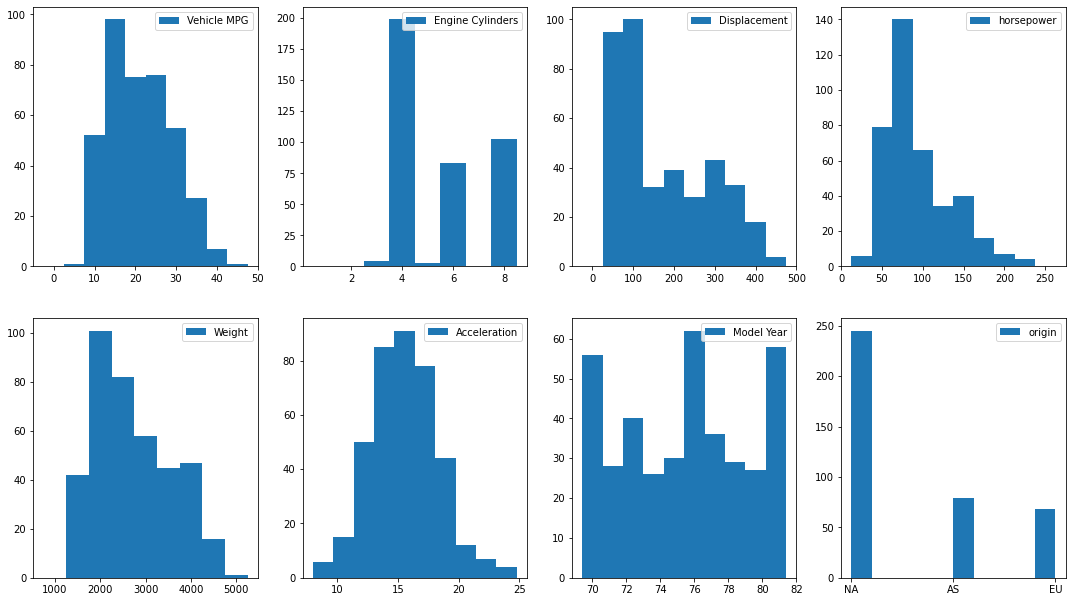

In [16]:
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(18.5, 10.5)

ax[0, 0].hist(df['mpg'], label="Vehicle MPG", bins=[0,5,10,15,20,25,30,35,40,45,50], align='left') #row=0, col=0
ax[0, 0].legend(loc="upper right")

ax[0, 1].hist(df['cylinders'], label="Engine Cylinders", bins=[1,2,3,4,5,6,7,8,9], align='left' ) #row=0, col=1
ax[0, 1].legend(loc="upper right")

ax[0, 2].hist(df['displacement'], label="Displacement", bins=[0,50,100,150,200,250,300,350,400,450,500], align='left' ) #row=0, col=2
ax[0, 2].legend(loc="upper right")

ax[0, 3].hist(df['horsepower'], label="horsepower", bins=[25,50,75,100,125,150,175,200,225,250,275], align='left' ) #row=0, col=3
ax[0, 3].legend(loc="upper right")

ax[1, 0].hist(df['weight'], label="Weight", bins=[1000,1500,2000,2500,3000,3500,4000,4500,5000,5500], align='left' ) #row=1, col=0
ax[1, 0].legend(loc="upper right")

ax[1, 1].hist(df['acceleration'], label="Acceleration") #row=1, col=1
ax[1, 1].legend(loc="upper right")

ax[1, 2].hist(df['model_year'], label="Model Year", align='left') #row=1, col=2
ax[1, 2].legend(loc="upper right")

ax[1, 3].hist(df['origin'], label="origin") #row=1, col=3
ax[1, 3].legend(loc="upper right")
plt.show()


### Continous Attribute Analysis for Dataset 2

**Attribute impact on fuel economy**\
Scatter plots of MPG vs displacement, horsepower, weight, acceleration, cylinders, model year show the correlation between fuel economy and these attributes.

Based on this there appears to be a negative correlation for MPG with displacement, horsepower, weight. There appears to be a positive correlation between mpg and model year. This makes sense as fuel economy has been improving as automobile manufacturers put more emphasis on this metric. The correlation between acceleration and MPG is not as clear however it does appear there might be a slight positive correlation between these two attributes.


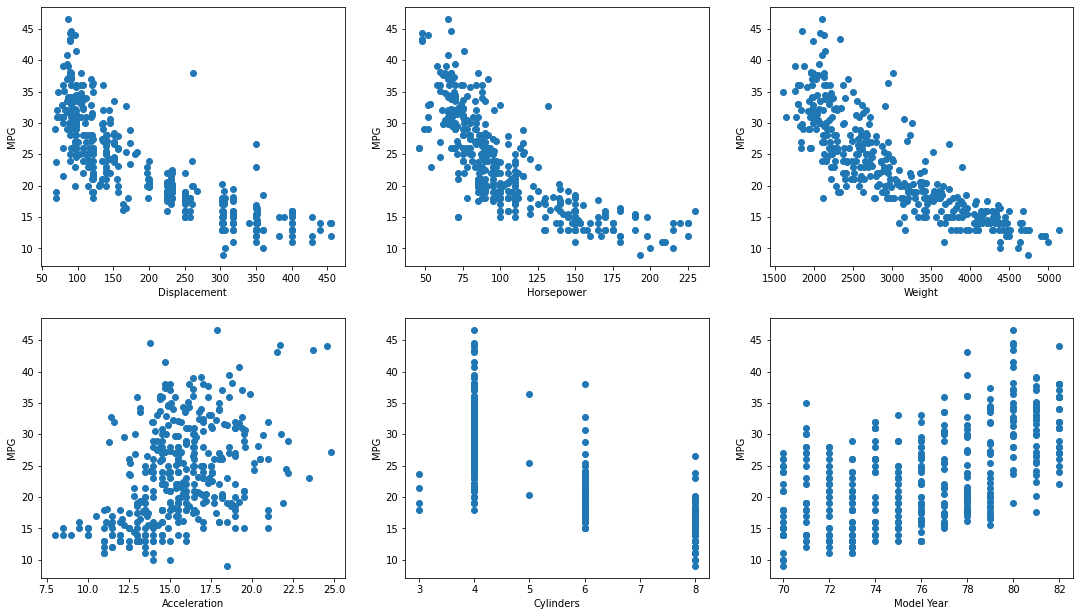

In [17]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(18.5, 10.5)

ax[0, 0].scatter(df['displacement'], df['mpg'])
ax[0, 0].set_xlabel('Displacement')
ax[0, 0].set_ylabel('MPG')


ax[0, 1].scatter(df['horsepower'], df['mpg'])
ax[0, 1].set_xlabel('Horsepower')
ax[0, 1].set_ylabel('MPG')

ax[0, 2].scatter(df['weight'], df['mpg'])
ax[0, 2].set_xlabel('Weight')
ax[0, 2].set_ylabel('MPG')

ax[1, 0].scatter(df['acceleration'], df['mpg'], label="Acceleration")
ax[1, 0].set_xlabel('Acceleration')
ax[1, 0].set_ylabel('MPG')

ax[1, 1].scatter(df['cylinders'], df['mpg'], label="Engine Cylinders")
ax[1, 1].set_xlabel('Cylinders')
ax[1, 1].set_ylabel('MPG')

ax[1, 2].scatter(df['model_year'], df['mpg'], label="Model Year")
ax[1, 2].set_xlabel('Model Year')
ax[1, 2].set_ylabel('MPG')

plt.show()

**Continous Attribute correlation**\
A scatterplot matrix shows the correlation between the attributes being analyzed to predict MPG. This shows a clear positive correlation between the displacement, horsepower, and weight attributes. There looks to be a negative correlation between acceleration and both displacement and horsepower. There might also be a negative correlation between acceleration and weight, however this is not as clear.

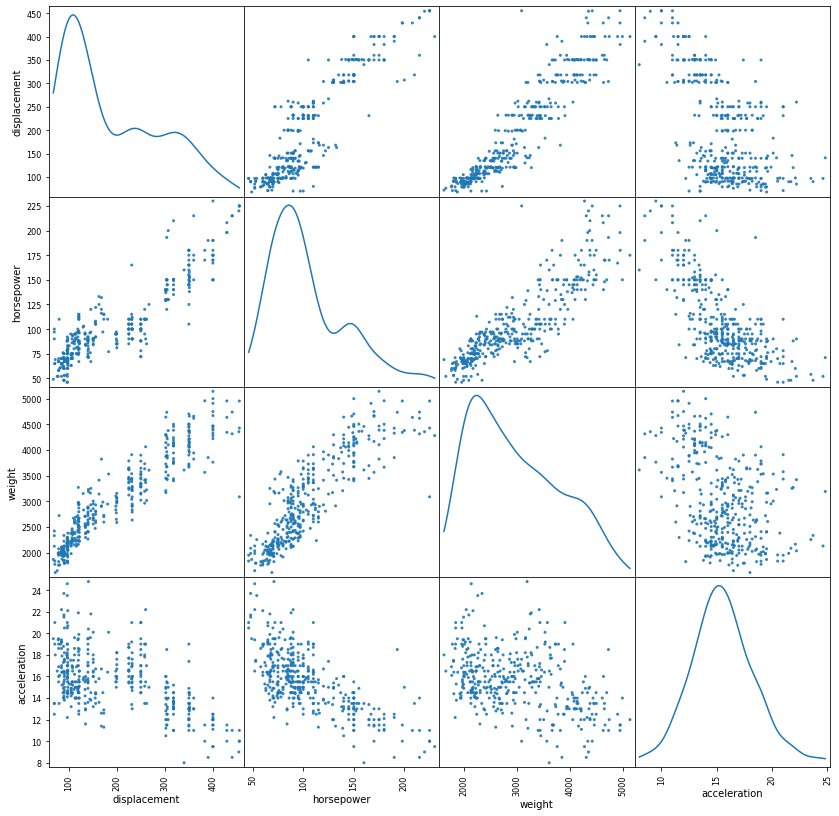

In [18]:
from pandas.plotting import scatter_matrix
df1 = pd.DataFrame()
df1['displacement'] = df['displacement']
df1['horsepower'] = df['horsepower']
df1['weight'] = df['weight']
df1['acceleration'] = df['acceleration']
scatter_matrix(df1, alpha = 0.9, figsize = (14, 14), diagonal = 'kde')
plt.show()

### Discrete Attribute Analysis for Dataset 1

Box plots of the discrete attributes show impact on MPG.

**Number of Cylinders**: The correlation between engine cylinders and MPG is not linear. It appears MPG peaks with 4 cyclinder engines.

Text(0.5, 1.0, '')

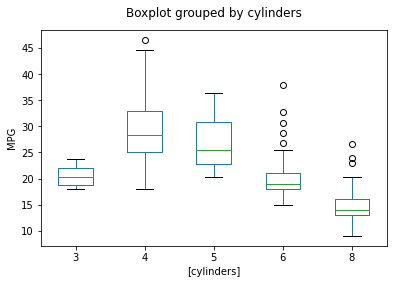

In [19]:
boxplot = df.boxplot(column=['mpg'], by=['cylinders'], grid=False)
boxplot.set_ylabel('MPG')
boxplot.set_title('')

**Production Year**: Production year seems to be positively correlated with MPG.

Text(0.5, 1.0, '')

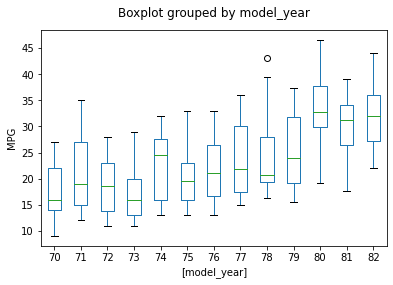

In [20]:
boxplot = df.boxplot(column=['mpg'], by=['model_year'], grid=False)
boxplot.set_ylabel('MPG')
boxplot.set_title('')

**Origin**: Car origin does seem to impact vehicle fuel economy (at least for the years in this dataset). It looks like North American cars have a lower MPG rating in general.

Text(0.5, 1.0, '')

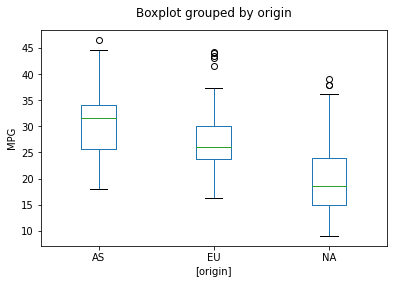

In [21]:
boxplot = df.boxplot(column=['mpg'], by=['origin'], grid=False)
boxplot.set_ylabel('MPG')
boxplot.set_title('')

## Initial Data Analysis Conclusions from Data Source 1

After initial exploration of the data it looks like all of the main attributes have at least some impact on vehicle fuel economy so none will be dropped at this time. The only attribute that was not explored is the unique make-model entry. For this attribute the next step will be to parse the text data in this field to extract the vehicle make. The make could be used as an addition discrete attribute to predict fuel economy.

Additionally, it does look like multiple of the attributes are correlated (engine displacement, horsepower, weight in particular). This will need to be considered when developing the regression model. It is very likely a number of these terms can be reduced in the final model.  

Based on the box plots there may be some outliers for multiple of these attributes. None of them look exceptionally bad (IE orders of magnitude outside the rest of the data). For now these will be left in the data but as models are built if it looks like these may be causing issues removal of these outliers will be considered. The datasets aren't particularly large, so I don't want to unnecessarily remove data at this stage.

# Dataset 2 Overview

The data set is a tabular data set in a single table that consists of 26 attribute columns. 
The first two columns are insurance related ratings and will not be useful for the purpose of this project. The next 24 columns are all attribute columns relating to car attributes including fuel economy. They are a mix of both continuous and categorial attributes. 



There are 205 unique entries in the dataset. The dataset was provided in a somewhat clean state designed for regression or classification analysis. However, the original intent was to rate or categorize cars for insurance risk. The dataset is being repurposed for regression analysis to predict MPG based on car attributes.

In [22]:
df2 = pd.read_csv('Auto.csv')

In [23]:
df2.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [24]:
# size of the data table
df2.shape

(205, 26)

## Dataset 2 Cleaning

The data provided is fairly clean but there are two columns that can be dropped immediately. The first two columns (symboling and normalized-losses) are for insurance metrics and will not be useful for MPG analysis. The data set did not use blanks for missing values. instead they used "?" for missing values. There are 12 total rows with '?' values in the dataset spread over various attributes. These rows will all be dropped for the purpose of this project. The removal of 12 out of 205 rows shouldn't impact the efficacy of the model. 

In [25]:
df2 = df2.drop('symboling', axis=1)
df2 = df2.drop('normalized-losses', axis=1)

In [26]:
df2.isnull().values.any()

False

In [27]:
df2[(df2 == '?').any(axis=1)]

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
9,audi,gas,turbo,two,hatchback,4wd,front,99.5,178.2,67.9,...,131,mpfi,3.13,3.4,7.0,160,5500,16,22,?
27,dodge,gas,turbo,?,sedan,fwd,front,93.7,157.3,63.8,...,98,mpfi,3.03,3.39,7.6,102,5500,24,30,8558
44,isuzu,gas,std,two,sedan,fwd,front,94.5,155.9,63.6,...,90,2bbl,3.03,3.11,9.6,70,5400,38,43,?
45,isuzu,gas,std,four,sedan,fwd,front,94.5,155.9,63.6,...,90,2bbl,3.03,3.11,9.6,70,5400,38,43,?
55,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,...,70,4bbl,?,?,9.4,101,6000,17,23,10945
56,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,...,70,4bbl,?,?,9.4,101,6000,17,23,11845
57,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,...,70,4bbl,?,?,9.4,101,6000,17,23,13645
58,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,...,80,mpfi,?,?,9.4,135,6000,16,23,15645
63,mazda,diesel,std,?,sedan,fwd,front,98.8,177.8,66.5,...,122,idi,3.39,3.39,22.7,64,4650,36,42,10795
129,porsche,gas,std,two,hatchback,rwd,front,98.4,175.7,72.3,...,203,mpfi,3.94,3.11,10.0,288,5750,17,28,?


In [28]:
df2 = df2[(df2 != '?').all(axis=1)]

In [29]:
df2.shape

(193, 24)

## Dataset 2 Attribute Overview

The 24 attributes are outlined below:\
**make**: The make of the car\
**fuel-type**: diesel or gas (categorical).\
**aspiration**: std or turbo (categorical).\
**num-of-doors**: four or two (categorical).\
**body-style**: hardtop, wagon, sedan, hatchback, or convertible (categorical).\
**drive-wheels**: 4wd, fwd, or rwd. (categorical)\
**engine-location**: front, rear. (categorical)\
**wheel-base**: Weel base length. Continuous from 86.6 120.9.\
**length**: Total Vehicle Length. Continuous from 141.1 to 208.1.\
**width**: Total Vehicle Widgth. Continuous from 60.3 to 72.3.\
**height**: Vehicle Height. Continuous from 47.8 to 59.8.\
**curb-weight**: Vehicle Weight. Continuous from 1488 to 4066.\
**engine-type**: Engine Type. dohc, dohcv, l, ohc, ohcf, ohcv, rotor.(categorical)\
**num-of-cylinders**: eight, five, four, six, three, twelve, two. (categorical)\
**engine-size**: Engine displacement volume. Continuous from 61 to 326.\
**fuel-system**: 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi. (categorical)\
**bore**: continuous from 2.54 to 3.94.\
**stroke**: continuous from 2.07 to 4.17.\
**compression-ratio**: continuous from 7 to 23.\
**horsepower**: continuous from 48 to 288.\
**peak-rpm**: continuous from 4150 to 6600.\
**city-mpg**: continuous from 13 to 49.\
**highway-mpg**: continuous from 16 to 54.\
**price**: continuous from 5118 to 45400.

In [30]:
#data types for each of the attributes in the data table
df2.dtypes

make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

In [31]:
df2['bore'] = df2['bore'].astype(float)
df2['stroke'] = df2['stroke'].astype(float)
df2['horsepower'] = df2['horsepower'].astype(float)
df2['peak-rpm'] = df2['peak-rpm'].astype(float)
df2['price'] = df2['price'].astype(float)

## Inital Data Analysis

Histograms of each of the attributes are shown below. Based on this the car dimension attributes (Length, Width etc.) appear to be normally distributed. The other continuous attributes don’t appear to follow normal distributions. The discrete attributes (make, fuel type, aspiration, number of doors etc.) do not appear to be uniformly distributed. It looks like the engine compression-ratio is directly related to the aspiration type as there are two clusters clearly dependent on if the engine is turbo charged or not. The data set does not contain a meaningful number of samples that have a rear engine so engine-location will most likely be dropped from the scope of the project 

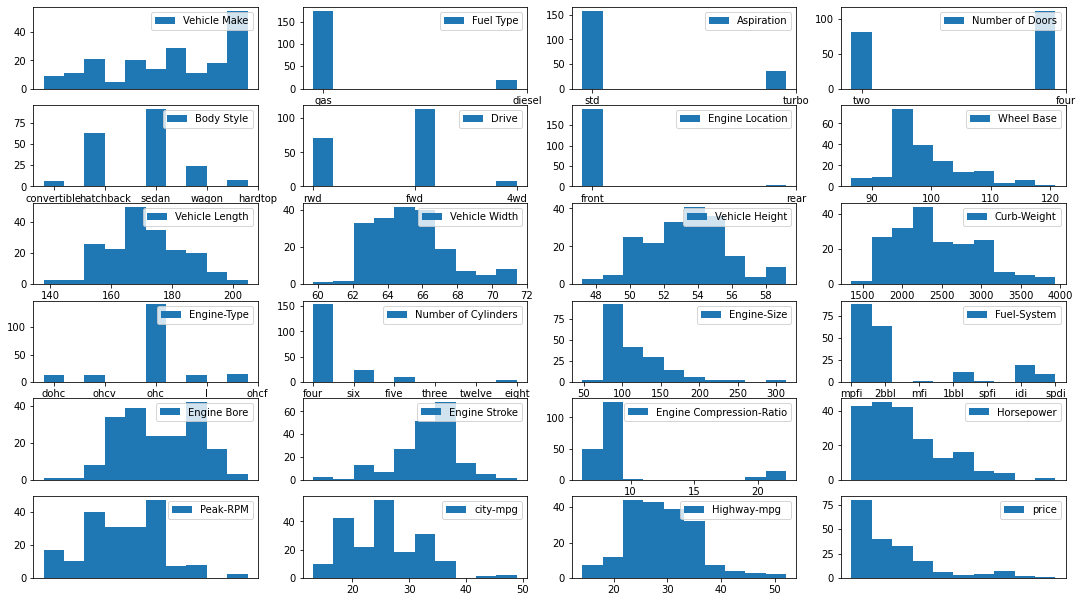

In [32]:
fig, ax = plt.subplots(6, 4)
fig.set_size_inches(18.5, 10.5)

ax[0, 0].hist(df2['make'], label="Vehicle Make", align='left') #row=0, col=0
ax[0, 0].legend(loc="upper right")
ax[0, 0].axes.get_xaxis().set_visible(False)

ax[0, 1].hist(df2['fuel-type'], label="Fuel Type", align='left' ) #row=0, col=1
ax[0, 1].legend(loc="upper right")

ax[0, 2].hist(df2['aspiration'], label="Aspiration", align='left' ) #row=0, col=2
ax[0, 2].legend(loc="upper right")

ax[0, 3].hist(df2['num-of-doors'], label="Number of Doors", align='left' ) #row=0, col=3
ax[0, 3].legend(loc="upper right")

ax[1, 0].hist(df2['body-style'], label="Body Style", align='left' ) #row=1, col=0
ax[1, 0].legend(loc="upper right")

ax[1, 1].hist(df2['drive-wheels'], label="Drive") #row=1, col=1
ax[1, 1].legend(loc="upper right")

ax[1, 2].hist(df2['engine-location'], label="Engine Location", align='left') #row=1, col=2
ax[1, 2].legend(loc="upper right")

ax[1, 3].hist(df2['wheel-base'], label="Wheel Base") #row=1, col=3
ax[1, 3].legend(loc="upper right")

ax[2, 0].hist(df2['length'], label="Vehicle Length", align='left') #row=2, col=0
ax[2, 0].legend(loc="upper right")

ax[2, 1].hist(df2['width'], label="Vehicle Width", align='left' ) #row=2, col=1
ax[2, 1].legend(loc="upper right")

ax[2, 2].hist(df2['height'], label="Vehicle Height", align='left' ) #row=2, col=2
ax[2, 2].legend(loc="upper right")

ax[2, 3].hist(df2['curb-weight'], label="Curb-Weight", align='left' ) #row=2, col=3
ax[2, 3].legend(loc="upper right")

ax[3, 0].hist(df2['engine-type'], label="Engine-Type", align='left' ) #row=2, col=0
ax[3, 0].legend(loc="upper right")

ax[3, 1].hist(df2['num-of-cylinders'], label="Number of Cylinders") #row=2, col=1
ax[3, 1].legend(loc="upper right")

ax[3, 2].hist(df2['engine-size'], label="Engine-Size", align='left') #row=2, col=2
ax[3, 2].legend(loc="upper right")

ax[3, 3].hist(df2['fuel-system'], label="Fuel-System") #row=2, col=3
ax[3, 3].legend(loc="upper right")

ax[4, 0].hist(df2['bore'], label="Engine Bore", align='left') #row=2, col=0
ax[4, 0].legend(loc="upper right")
ax[4, 0].axes.get_xaxis().set_visible(False)

ax[4, 1].hist(df2['stroke'], label="Engine Stroke", align='left' ) #row=2, col=1
ax[4, 1].legend(loc="upper right")
ax[4, 1].axes.get_xaxis().set_visible(False)

ax[4, 2].hist(df2['compression-ratio'], label="Engine Compression-Ratio", align='left' ) #row=2, col=2
ax[4, 2].legend(loc="upper right")

ax[4, 3].hist(df2['horsepower'], label="Horsepower", align='left' ) #row=2, col=3
ax[4, 3].legend(loc="upper right")
ax[4, 3].axes.get_xaxis().set_visible(False)

ax[5, 0].hist(df2['peak-rpm'], label="Peak-RPM", align='left' ) #row=2, col=0
ax[5, 0].legend(loc="upper right")
ax[5, 0].axes.get_xaxis().set_visible(False)

ax[5, 1].hist(df2['city-mpg'], label="city-mpg") #row=2, col=1
ax[5, 1].legend(loc="upper right")

ax[5, 2].hist(df2['highway-mpg'], label="Highway-mpg  ", align='left') #row=2, col=2
ax[5, 2].legend(loc="upper right")

ax[5, 3].hist(df2['price'], label="price") #row=2, col=3
ax[5, 3].legend(loc="upper right")
ax[5, 3].axes.get_xaxis().set_visible(False)

plt.show()

### Continous Attribute Analysis for Data Source 2

**Continous Attribute Correlation**

A scatterplot matrix shows the correlation between the continuous attributes being analyzed to predict MPG. This shows a clear positive correlation between the vehicle dimensions (length, wheelbase, width, engine size). Again, compression ratio appears to be clustered in two groups depending on engine aspiration. The second dataset has both city and highway MPG and there is direct positive correlation there as expected. It appears car horsepower has a negative correlation with MPG however it may not be linear. Curb weight and engine size also appear to have negative correlation with MPG. Surprisingly the car dimensions don't have as clearly a defined negative correlation to MPG as other attributes. Width, Length, and wheelbase do have a negative correlation, but height does not appear to be correlated. Stroke does not appear to have correlations and it’s hard to tell from the plot if compression ratio does. It is possible there aren't enough turbo charged samples in the dataset to make a meaningful conclusion.

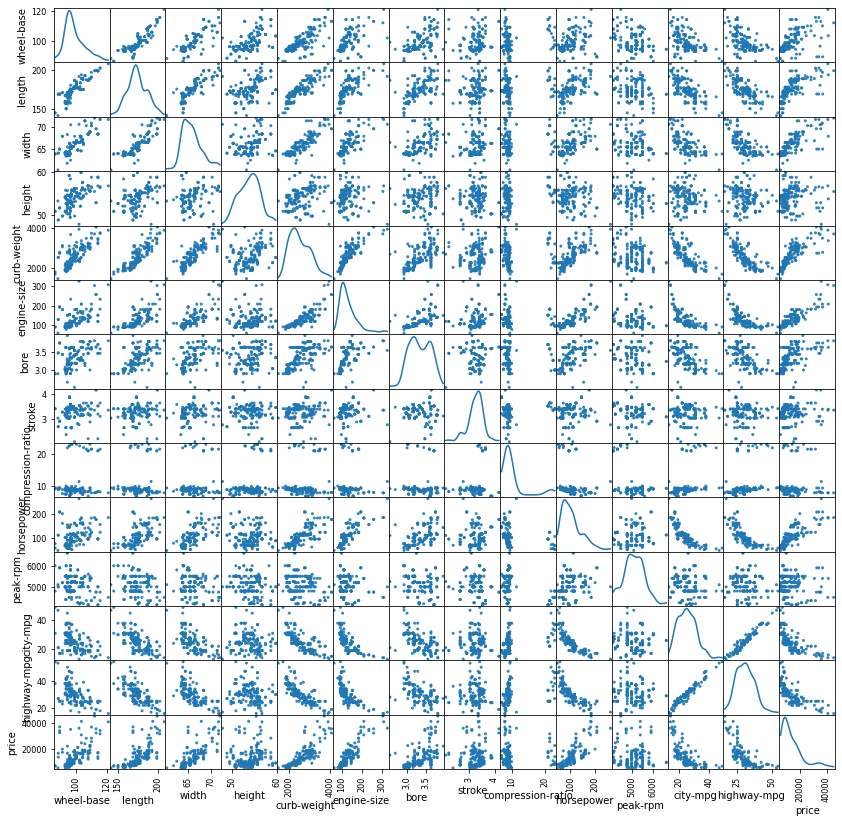

In [33]:
scatter_matrix(df2, alpha = 0.9, figsize = (14, 14), diagonal = 'kde');
plt.show()

### Discrete Attribute Analysis for Data Source 2

Box plots of the discrete attributes and city MPG are shown below. In general it appears these factors certainly impact MPG. However, many of them may not be useful for the model. Many of these attributes are not uniformly distributed and heavily skewed towards one or two types. 

**Make**: Based on the boxplot below there does seem to be variation in MPG from MFG to MFG. It looks like the sample size for many of the Manufacturers is small enough that it may not be possible to make a meaningful conclusion. 

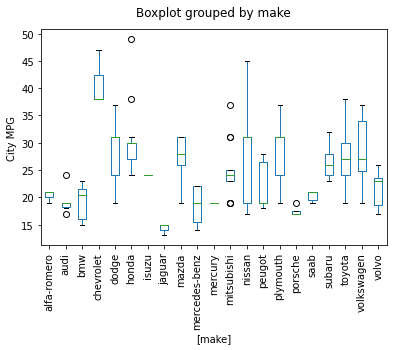

In [34]:
boxplot = df2.boxplot(column=['city-mpg'], by=['make'], grid=False)
boxplot.set_ylabel('City MPG')
boxplot.set_title('')
plt.xticks(rotation=90)
plt.show()

In [35]:
df2[["make", "price"]].groupby(["make"]).count()

,price
make,
alfa-romero,3
audi,6
bmw,8
chevrolet,3
dodge,8
honda,13
isuzu,2
jaguar,3
mazda,12


**Fuel Economy**: It does appear that there is a distinct difference in fuel econonmy between diesel and gas engines however the number of diesel samples is significantly smaller than the number of gas samples.

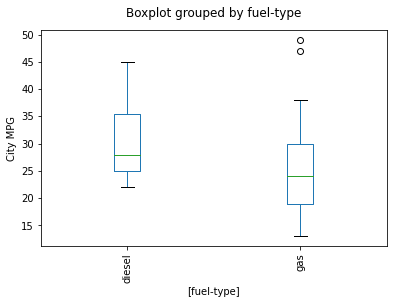

In [36]:
boxplot = df2.boxplot(column=['city-mpg'], by=['fuel-type'], grid=False)
boxplot.set_ylabel('City MPG')
boxplot.set_title('')
plt.xticks(rotation=90)
plt.show()

In [37]:
df2[["fuel-type", "price"]].groupby(["fuel-type"]).count()

,price
fuel-type,
diesel,19
gas,174


**Aspiration Type**: It does appear that there is a distinct difference in fuel econonmy between naturally aspirated and turbo charges vehicles however again the number of samples of turbo charges vehicles is significantly smaller than the naturally aspirated. Suprisingly the turbo charged vehicles have a lower MPG. This does not align with current trends where turbo chargers are being utilized more and more because of significant fuel economy advantages.

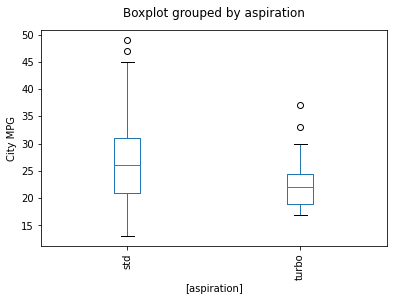

In [38]:
boxplot = df2.boxplot(column=['city-mpg'], by=['aspiration'], grid=False)
boxplot.set_ylabel('City MPG')
boxplot.set_title('')
plt.xticks(rotation=90)
plt.show()

**Number of doors**: The fuel economy mean is very similar for both two and four door vehicles however the range for two doors is much larger

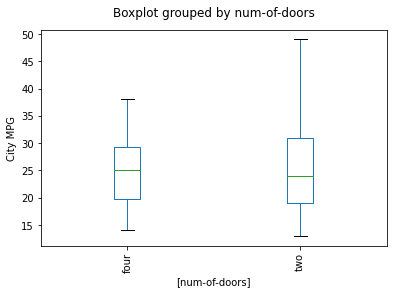

In [39]:
boxplot = df2.boxplot(column=['city-mpg'], by=['num-of-doors'], grid=False)
boxplot.set_ylabel('City MPG')
boxplot.set_title('')
plt.xticks(rotation=90)
plt.show()

**Body Type**: The vehicle body type does appear to impact fuel economy. This may partially be due to a skewed number of samples for sedans and hatchbacks

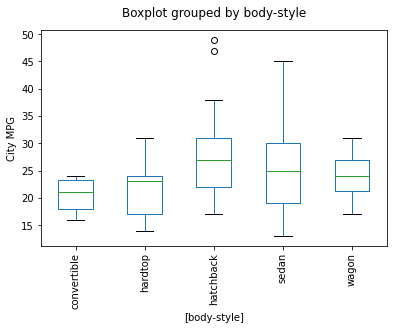

In [40]:
boxplot = df2.boxplot(column=['city-mpg'], by=['body-style'], grid=False)
boxplot.set_ylabel('City MPG')
boxplot.set_title('')
plt.xticks(rotation=90)
plt.show()

In [41]:
df2[["body-style", "price"]].groupby(["body-style"]).count()

,price
body-style,
convertible,6
hardtop,8
hatchback,63
sedan,92
wagon,24


**Drive Train**: The vehicle drive train does appear to have a significant impact on fuel economy. There aren't a lot of 4wd samples in the dataset however so that may skew the results. 

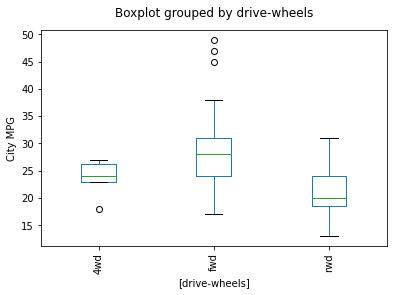

In [42]:
boxplot = df2.boxplot(column=['city-mpg'], by=['drive-wheels'], grid=False)
boxplot.set_ylabel('City MPG')
boxplot.set_title('')
plt.xticks(rotation=90)
plt.show()

In [43]:
df2[["drive-wheels", "price"]].groupby(["drive-wheels"]).count()

,price
drive-wheels,
4wd,8
fwd,114
rwd,71


**Engine Location**: Nothing meaningful can be determined from the engine location. Only 1 sample for rear engine exists in the dataset. Engine location will be excluded from the scope of this project. 

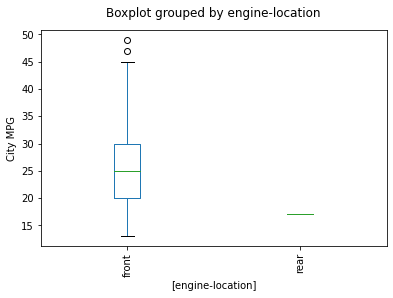

In [44]:
boxplot = df2.boxplot(column=['city-mpg'], by=['engine-location'], grid=False)
boxplot.set_ylabel('City MPG')
boxplot.set_title('')
plt.xticks(rotation=90)
plt.show()

**Engine Type**: There does appear to be meaningful differences between fuel economy of different engine types. Again however the data is very skewed with the vast majority of the samples being OHC engines.

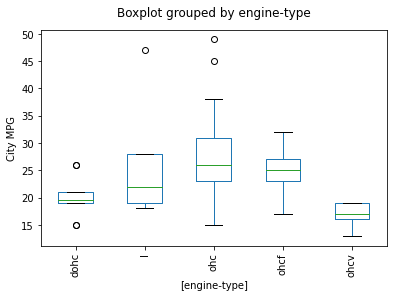

In [45]:
boxplot = df2.boxplot(column=['city-mpg'], by=['engine-type'], grid=False)
boxplot.set_ylabel('City MPG')
boxplot.set_title('')
plt.xticks(rotation=90)
plt.show()

In [46]:
df2[["engine-type", "price"]].groupby(["engine-type"]).count()

,price
engine-type,
dohc,12
l,12
ohc,141
ohcf,15
ohcv,13


**Number of cylinders**: There does appear to be meaningful differences between fuel economy for diffent numbers of cylinders in the engine. Again however the data is very skewed with the vast majority of the samples being four cylinders.

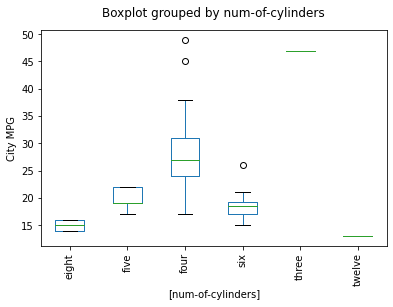

In [47]:
boxplot = df2.boxplot(column=['city-mpg'], by=['num-of-cylinders'], grid=False)
boxplot.set_ylabel('City MPG')
boxplot.set_title('')
plt.xticks(rotation=90)
plt.show()

In [48]:
df2[["num-of-cylinders", "price"]].groupby(["num-of-cylinders"]).count()

,price
num-of-cylinders,
eight,4
five,10
four,153
six,24
three,1
twelve,1


**Fuel System Type**: There does appear to be meaningful differences between fuel economy for diffent fuel systems. Again however the data is very skewed with the vast majority of the samples being either 2bbl or mpfi systems.

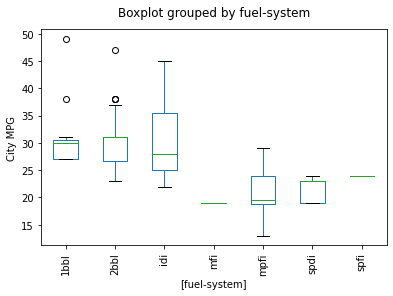

In [49]:
boxplot = df2.boxplot(column=['city-mpg'], by=['fuel-system'], grid=False)
boxplot.set_ylabel('City MPG')
boxplot.set_title('')
plt.xticks(rotation=90)
plt.show()

In [50]:
df2[["fuel-system", "price"]].groupby(["fuel-system"]).count()

,price
fuel-system,
1bbl,11
2bbl,64
idi,19
mfi,1
mpfi,88
spdi,9
spfi,1


## Initial Data Analysis Conclusions from Data Source 2

After initial exploration of the data, it looks most of the attributes have at least some impact on fuel economy. The engine location attribute will be removed from the scope of this project as there a not enough samples for rear engine to make any meaningful conclusions. Pretty much all of the other categorical attributes (make, fuel system, number of cylinders, engine type, body style, aspiration etc.) are not uniformly distributed and in many cases heavily skewed towards 1 category. This might hinder the regression model efficacy when utilizing these attributes. A few of the categories within each categorical attribute do not have enough data to warrent including in the model. Additionally, just like with the data from source 1, it does look like multiple of the attributes are highly correlated (engine displacement, horsepower, vehicle dimensions). This will need to be considered when developing the regression model as multiple of these terms can probably be dropped from the final model. 

Again, based on the box plots and scatter plots there may be some outliers for multiple of these attributes. None of them look exceptionally bad however. For now, these will be left in the data but as models are built if it looks like these may be causing issues removal of these outliers will be considered. The datasets aren't particularly large, so I don't want to unnecessarily remove data at this stage.

# Model Development for Dataset #1

## Determing factors that may not be linear

The model for dataset 1 will be developed using forward stepwise selection. Based on the information discovered in the data exploration section multiple factors are most likely not linear. Displacement, horsepower, and weight are all most likely negatively exponentially or logarithmically related to MPG. To determine which of these parameters is not linear and what the best nonlinear model is each of these factors was modeled individually below using linear, exponenial, and logarithmic models.

In [51]:
# Building linear, exponential, lin-log, and log-log models for the factors identified in the data exploration section that most likely are not linear.
model_dataset1_lincheck_01 = smf.ols(formula='mpg~displacement', data=df).fit()
model_dataset1_lincheck_02 = smf.ols(formula='mpg~horsepower', data=df).fit()
model_dataset1_lincheck_03 = smf.ols(formula='mpg~weight', data=df).fit()

model_dataset1_expcheck_01 = smf.ols(formula='mpg~displacement + np.power(displacement,2)', data=df).fit()
model_dataset1_expcheck_02 = smf.ols(formula='mpg~horsepower + np.power(horsepower,2)', data=df).fit()
model_dataset1_expcheck_03 = smf.ols(formula='mpg~weight + np.power(weight,2)', data=df).fit()

model_dataset1_logcheck_01 = smf.ols(formula='mpg~np.log(displacement)', data=df).fit()
model_dataset1_logcheck_02 = smf.ols(formula='mpg~np.log(horsepower)', data=df).fit()
model_dataset1_logcheck_03 = smf.ols(formula='mpg~np.log(weight)', data=df).fit()

model_dataset1_loglogcheck_01 = smf.ols(formula='np.log(mpg)~np.log(displacement)', data=df).fit()
model_dataset1_loglogcheck_02 = smf.ols(formula='np.log(mpg)~np.log(horsepower)', data=df).fit()
model_dataset1_loglogcheck_03 = smf.ols(formula='np.log(mpg)~np.log(weight)', data=df).fit()

In [52]:
# Printing the R^2 values to confirm appropriate model
L = [model_dataset1_lincheck_01,model_dataset1_lincheck_02,model_dataset1_lincheck_03]
L2 = [model_dataset1_expcheck_01,model_dataset1_expcheck_02,model_dataset1_expcheck_03]
L3 = [model_dataset1_logcheck_01,model_dataset1_logcheck_02,model_dataset1_logcheck_03]
L4 = [model_dataset1_loglogcheck_01,model_dataset1_loglogcheck_02,model_dataset1_loglogcheck_03]

print("linear models:")
for model in L:
    print (model.rsquared_adj)

print("")
print("exponential models:")
for model in L2:
    print (model.rsquared_adj)
    
print("")
print("Linear-logarithmic models:")
for model in L3:
    print (model.rsquared_adj)
    
print("")
print("Logarithmic-logarithmic models:")
for model in L4:
    print (model.rsquared_adj)

linear models:
0.6473274244226872
0.6049378688071001
0.691842306026063

exponential models:
0.6872087782252561
0.6859526502069047
0.7136830187962594

Linear-logarithmic models:
0.685530620307738
0.6674843404374681
0.7119263731957113

Logarithmic-logarithmic models:
0.7390881618477987
0.7219857172647972
0.7641663516074264


Based on these results it looks like a log-log model is the best fit for displacement, horsepower, and weight. Plots for each are shown below to confirm these results

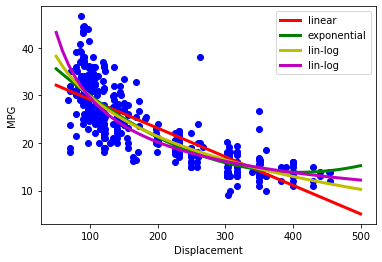

In [53]:
# Displacment Model Fit Plots
plt.plot(df.displacement, df.mpg, 'bo');
xticks = np.linspace(50,500)
plt.plot(xticks, model_dataset1_lincheck_01.params[0] + xticks * model_dataset1_lincheck_01.params[1], 'r', lw=3, label='linear');
plt.plot(xticks, model_dataset1_expcheck_01.params[0] + xticks * model_dataset1_expcheck_01.params[1] + xticks*xticks*model_dataset1_expcheck_01.params[2], 'g', lw=3, label='exponential');
plt.plot(xticks, model_dataset1_logcheck_01.params[0] + np.log(xticks) * model_dataset1_logcheck_01.params[1], 'y', lw=3, label='lin-log');
plt.plot(xticks, np.exp(model_dataset1_loglogcheck_01.params[0] + np.log(xticks) * model_dataset1_loglogcheck_01.params[1]), 'm', lw=3, label='lin-log');
plt.xlabel('Displacement');
plt.ylabel('MPG');
plt.legend()

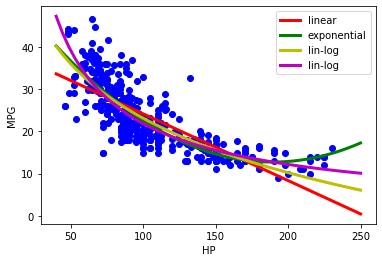

In [54]:
# Horsepower Model Fit Plots
plt.plot(df.horsepower, df.mpg, 'bo');
xticks = np.linspace(40,250)
plt.plot(xticks, model_dataset1_lincheck_02.params[0] + xticks * model_dataset1_lincheck_02.params[1], 'r', lw=3, label='linear');
plt.plot(xticks, model_dataset1_expcheck_02.params[0] + xticks * model_dataset1_expcheck_02.params[1] + xticks*xticks*model_dataset1_expcheck_02.params[2], 'g', lw=3, label='exponential');
plt.plot(xticks, model_dataset1_logcheck_02.params[0] + np.log(xticks) * model_dataset1_logcheck_02.params[1], 'y', lw=3, label='lin-log');
plt.plot(xticks, np.exp(model_dataset1_loglogcheck_02.params[0] + np.log(xticks) * model_dataset1_loglogcheck_02.params[1]), 'm', lw=3, label='lin-log');
plt.xlabel('HP');
plt.ylabel('MPG');
plt.legend()

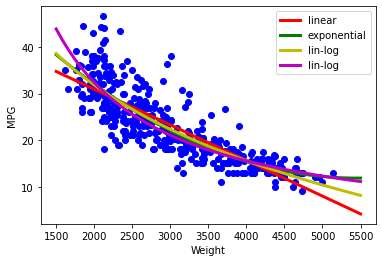

In [55]:
# Weight Model Fit Plots
plt.plot(df.weight, df.mpg, 'bo');
xticks = np.linspace(1500,5500)
plt.plot(xticks, model_dataset1_lincheck_03.params[0] + xticks * model_dataset1_lincheck_03.params[1], 'r', lw=3, label='linear');
plt.plot(xticks, model_dataset1_expcheck_03.params[0] + xticks * model_dataset1_expcheck_03.params[1] + xticks*xticks*model_dataset1_expcheck_03.params[2], 'g', lw=3, label='exponential');
plt.plot(xticks, model_dataset1_logcheck_03.params[0] + np.log(xticks) * model_dataset1_logcheck_03.params[1], 'y', lw=3, label='lin-log');
plt.plot(xticks, np.exp(model_dataset1_loglogcheck_03.params[0] + np.log(xticks) * model_dataset1_loglogcheck_03.params[1]), 'm', lw=3, label='lin-log');
plt.xlabel('Weight');
plt.ylabel('MPG');
plt.legend()

## Forward Stepwise Selection

Forward Stepwise Selection will be utilized to select attributes to include in the model. Each iteration is outlined below.

In [56]:
# Iteration 1
model_dataset1_fss01_01 = smf.ols(formula='mpg ~ cylinders', data=df).fit()
model_dataset1_fss01_02 = smf.ols(formula='np.log(mpg) ~ np.log(displacement)', data=df).fit()
model_dataset1_fss01_03 = smf.ols(formula='np.log(mpg) ~ np.log(horsepower)', data=df).fit()
model_dataset1_fss01_04 = smf.ols(formula='np.log(mpg) ~ np.log(weight)', data=df).fit()
model_dataset1_fss01_05 = smf.ols(formula='mpg ~ acceleration', data=df).fit()
model_dataset1_fss01_06 = smf.ols(formula='mpg ~ model_year', data=df).fit()
model_dataset1_fss01_07 = smf.ols(formula='mpg ~ origin', data=df).fit()

Lmodels = [model_dataset1_fss01_01, model_dataset1_fss01_02, model_dataset1_fss01_03, model_dataset1_fss01_04, model_dataset1_fss01_05, model_dataset1_fss01_06, model_dataset1_fss01_07]

Lnames = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']

for model,name in zip(Lmodels, Lnames):
    print(name + " R squared: " + str(model.rsquared_adj))

cylinders R squared: 0.6036753709670583
displacement R squared: 0.7390881618477987
horsepower R squared: 0.7219857172647972
weight R squared: 0.7641663516074264
acceleration R squared: 0.17710245284896298
model_year R squared: 0.3353278846258013
origin R squared: 0.32841301146568735


In [57]:
# check model with best r^2 value
model_dataset1_fss01_04.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     1268.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          1.27e-124
Time:                        00:41:15   Log-Likelihood:                 150.77
No. Observations:                 392   AIC:                            -297.5
Df Residuals:                     390   BIC:                            -289.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.5152      0.237     48.686      0.000      11.050      11.980
np.log(weight)    -1.0575      0.030    -35.608      0.000      -1.116      -0.999
==============================================================================
Omnibus:                       11.449   Durbin-Watson:                   0.772
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.082
Skew:                           0.290   Prob(JB):                     0.000875
Kurtosis:                       3.725   Cond. No.                         229.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
#Iteration 2
model_dataset1_fss02_01 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + cylinders', data=df).fit()
model_dataset1_fss02_02 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + np.log(displacement)', data=df).fit()
model_dataset1_fss02_03 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + np.log(horsepower)', data=df).fit()
model_dataset1_fss02_04 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + acceleration', data=df).fit()
model_dataset1_fss02_05 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year', data=df).fit()
model_dataset1_fss02_06 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + origin', data=df).fit()

Lmodels = [model_dataset1_fss02_01, model_dataset1_fss02_02, model_dataset1_fss02_03, model_dataset1_fss02_04, model_dataset1_fss02_05, model_dataset1_fss02_06]

Lnames = ['cylinders', 'displacement', 'horsepower', 'acceleration', 'model_year', 'origin']

for model,name in zip(Lmodels, Lnames):
    print(name + " R squared: " + str(model.rsquared_adj))

cylinders R squared: 0.7767524922545923
displacement R squared: 0.7750057851955279
horsepower R squared: 0.7949103251677277
acceleration R squared: 0.7746972791407167
model_year R squared: 0.8801297183215755
origin R squared: 0.7642108311289992


In [59]:
#check model with best R^2 value
model_dataset1_fss02_05.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1436.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          2.38e-180
Time:                        00:41:15   Log-Likelihood:                 283.91
No. Observations:                 392   AIC:                            -561.8
Df Residuals:                     389   BIC:                            -549.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.0395      0.246     32.720      0.000       7.556       8.523
np.log(weight)    -0.9341      0.022    -42.259      0.000      -0.978      -0.891
model_year         0.0328      0.002     19.450      0.000       0.029       0.036
==============================================================================
Omnibus:                        9.424   Durbin-Watson:                   1.396
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               16.664
Skew:                           0.022   Prob(JB):                     0.000241
Kurtosis:                       4.009   Cond. No.                     3.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based on Note 2 from the summary table output, the condition number is large indicating multicollinearity might already be an issue with the model. VIR factors are calculated below to confirm this

In [60]:
# check the Variance Inflation Factor to see if multicolinearity is impacting the model
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['weight', 'model_year']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

      feature        VIF
0      weight  11.751992
1  model_year  11.751992


Based on the VIR there is definitely collinearity happening after including just 2 factors. Unfortunately not including model year results in a model with no real gain over just 1 factor of weight. Additional factors will be added to see if model is okay in spite of multicolinearity issues. 

In [61]:
model_dataset1_fss03_01 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + cylinders ', data=df).fit()
model_dataset1_fss03_02 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + np.log(displacement)', data=df).fit()
model_dataset1_fss03_03 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + np.log(horsepower)', data=df).fit()
model_dataset1_fss03_04 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + acceleration', data=df).fit()
model_dataset1_fss03_05 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + origin', data=df).fit()

Lmodels = [model_dataset1_fss03_01, model_dataset1_fss03_02, model_dataset1_fss03_03, model_dataset1_fss03_04, model_dataset1_fss03_05]

Lnames = ['cylinders', 'displacement', 'horsepower', 'acceleration', 'origin']

for model,name in zip(Lmodels, Lnames):
    print(name + " R squared: " + str(model.rsquared_adj))

cylinders R squared: 0.8819214792796294
displacement R squared: 0.8818099014867603
horsepower R squared: 0.8852485882737289
acceleration R squared: 0.8812823068364005
origin R squared: 0.8826432695349963


In [62]:
model_dataset1_fss03_03.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1006.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          1.30e-182
Time:                        00:41:15   Log-Likelihood:                 292.97
No. Observations:                 392   AIC:                            -577.9
Df Residuals:                     388   BIC:                            -562.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.6719      0.255     30.057      0.000       7.170       8.174
np.log(weight)        -0.7748      0.043    -18.012      0.000      -0.859      -0.690
model_year             0.0305      0.002     17.528      0.000       0.027       0.034
np.log(horsepower)    -0.1575      0.037     -4.284      0.000      -0.230      -0.085
==============================================================================
Omnibus:                        5.436   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                7.530
Skew:                          -0.013   Prob(JB):                       0.0232
Kurtosis:                       3.678   Cond. No.                     3.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
X = df[['weight', 'model_year', 'horsepower']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

      feature        VIF
0      weight  53.386115
1  model_year  12.330554
2  horsepower  33.823703


In [64]:
model_dataset1_fss03_05.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     736.2
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          2.10e-179
Time:                        00:41:15   Log-Likelihood:                 289.08
No. Observations:                 392   AIC:                            -568.2
Df Residuals:                     387   BIC:                            -548.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.6460      0.277     27.594      0.000       7.101       8.191
origin[T.EU]       0.0279      0.020      1.427      0.154      -0.011       0.066
origin[T.NA]      -0.0304      0.019     -1.643      0.101      -0.067       0.006
np.log(weight)    -0.8883      0.028    -31.970      0.000      -0.943      -0.834
model_year         0.0334      0.002     19.813      0.000       0.030       0.037
==============================================================================
Omnibus:                        8.543   Durbin-Watson:                   1.402
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               12.682
Skew:                          -0.136   Prob(JB):                      0.00176
Kurtosis:                       3.838   Cond. No.                     3.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
test = df.copy()
test['origin'] = test['origin'].map({'NA':0, 'EU':1, 'AS':2})
X = test[['weight', 'model_year', 'origin']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

      feature        VIF
0      weight  17.290021
1  model_year  21.579623
2      origin   2.252614


The best model with 3 factors is weight, model_year, horespower however the VIFs for those factors indicate that the multicollinearity is quite high. The next best option is weight, model_year, origin which has lower VIFs. It does not look like this model has added a new multicollinear term. However based on the P value for all of the origin terms none of them appear to be significant.  

## Testing for interactions

The model attributes will be tested for interations. Each combination was added to the weight + model_year model determined above. 

In [66]:
# building models for each of the interactions
model_dataset1_interactions_01_01 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + cylinders * displacement', data=df).fit()
model_dataset1_interactions_01_02 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + cylinders * horsepower', data=df).fit()
model_dataset1_interactions_01_03 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + cylinders * weight', data=df).fit()
model_dataset1_interactions_01_04 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + cylinders * acceleration', data=df).fit()
model_dataset1_interactions_01_05 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + cylinders * model_year', data=df).fit()
model_dataset1_interactions_01_06 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + cylinders * origin', data=df).fit()
model_dataset1_interactions_01_07 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + displacement * horsepower', data=df).fit()
model_dataset1_interactions_01_08 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + displacement * weight', data=df).fit()
model_dataset1_interactions_01_09 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + displacement * acceleration', data=df).fit()
model_dataset1_interactions_01_10 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + displacement * model_year', data=df).fit()
model_dataset1_interactions_01_11 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + displacement * origin', data=df).fit()
model_dataset1_interactions_01_12 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + horsepower * weight', data=df).fit()
model_dataset1_interactions_01_13 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + horsepower * acceleration', data=df).fit()
model_dataset1_interactions_01_14 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + horsepower * model_year', data=df).fit()
model_dataset1_interactions_01_15 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + horsepower * origin', data=df).fit()
model_dataset1_interactions_01_16 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + weight * acceleration', data=df).fit()
model_dataset1_interactions_01_17 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + weight * model_year', data=df).fit()
model_dataset1_interactions_01_18 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + weight * origin', data=df).fit()
model_dataset1_interactions_01_19 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + acceleration * model_year', data=df).fit()
model_dataset1_interactions_01_20 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + acceleration * origin', data=df).fit()
model_dataset1_interactions_01_21 = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + model_year * origin', data=df).fit()

In [67]:
# outputing all the R^2 values from each of the models
Lnumbers = list(range(1,22))
Lmodels = [model_dataset1_interactions_01_01, model_dataset1_interactions_01_02, model_dataset1_interactions_01_03, model_dataset1_interactions_01_04, model_dataset1_interactions_01_05, model_dataset1_interactions_01_06,
          model_dataset1_interactions_01_07, model_dataset1_interactions_01_08, model_dataset1_interactions_01_09, model_dataset1_interactions_01_10, model_dataset1_interactions_01_11, model_dataset1_interactions_01_12,
          model_dataset1_interactions_01_13, model_dataset1_interactions_01_14, model_dataset1_interactions_01_15, model_dataset1_interactions_01_16, model_dataset1_interactions_01_17, model_dataset1_interactions_01_18,
          model_dataset1_interactions_01_19, model_dataset1_interactions_01_20, model_dataset1_interactions_01_21]

for model,number in zip(Lmodels, Lnumbers):
    print(str(number) + ". R squared: " + str(model.rsquared_adj))

1. R squared: 0.8817917438622982
2. R squared: 0.8869658419276087
3. R squared: 0.8815711664452812
4. R squared: 0.8838585994801845
5. R squared: 0.882013736362126
6. R squared: 0.8840149243489748
7. R squared: 0.8898246237762525
8. R squared: 0.8837600094421366
9. R squared: 0.8853951187008172
10. R squared: 0.8816736803924651
11. R squared: 0.8822688797229832
12. R squared: 0.8859683780864533
13. R squared: 0.8913341153853387
14. R squared: 0.8871818680602047
15. R squared: 0.8875660413992111
16. R squared: 0.8823451514750257
17. R squared: 0.8795999673341539
18. R squared: 0.8824358083724793
19. R squared: 0.8884021761739677
20. R squared: 0.8893946021258275
21. R squared: 0.8828108211352964


In [68]:
#Selecting the model with the best R^2
model_dataset1_interactions_01_13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     642.4
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          1.33e-184
Time:                        00:41:15   Log-Likelihood:                 304.67
No. Observations:                 392   AIC:                            -597.3
Df Residuals:                     386   BIC:                            -573.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   6.3008      0.362     17.386      0.000       5.588       7.013
np.log(weight)             -0.7136      0.047    -15.102      0.000      -0.807      -0.621
model_year                  0.0312      0.002     18.191      0.000       0.028       0.035
horsepower                  0.0022      0.001      3.043      0.003       0.001       0.004
acceleration                0.0235      0.005      4.357      0.000       0.013       0.034
horsepower:acceleration    -0.0003   5.57e-05     -5.578      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       11.375   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.929
Skew:                          -0.189   Prob(JB):                     0.000128
Kurtosis:                       3.977   Cond. No.                     1.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
test = df.copy()
test['origin'] = test['origin'].map({'NA':0, 'EU':1, 'AS':2})
X = test[['weight', 'model_year', 'horsepower','acceleration']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

        feature        VIF
0        weight  66.858723
1    model_year  91.254028
2    horsepower  55.837598
3  acceleration  66.320846


Based on the summary of the best performing model with interactions, it is very likely the horsepower*acceleration term is not significant. It looks like the confidence interval is right at zero but it may not cross it. Based on the VIF terms though there certainly is multicollinearity happening.

In [70]:
#selecting the next best model
model_dataset1_interactions_01_20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     450.2
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          9.36e-181
Time:                        00:41:15   Log-Likelihood:                 302.22
No. Observations:                 392   AIC:                            -588.4
Df Residuals:                     384   BIC:                            -556.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     7.6455      0.312     24.496      0.000       7.032       8.259
origin[T.EU]                 -0.2116      0.133     -1.586      0.114      -0.474       0.051
origin[T.NA]                  0.1533      0.115      1.329      0.185      -0.073       0.380
np.log(weight)               -0.9033      0.029    -31.135      0.000      -0.960      -0.846
model_year                    0.0333      0.002     19.678      0.000       0.030       0.037
acceleration                  0.0078      0.007      1.173      0.242      -0.005       0.021
acceleration:origin[T.EU]     0.0140      0.008      1.737      0.083      -0.002       0.030
acceleration:origin[T.NA]    -0.0113      0.007     -1.581      0.115      -0.025       0.003
==============================================================================
Omnibus:                       11.350   Durbin-Watson:                   1.558
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               16.642
Skew:                          -0.219   Prob(JB):                     0.000243
Kurtosis:                       3.909   Cond. No.                     4.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
test = df.copy()
test['origin'] = test['origin'].map({'NA':0, 'EU':1, 'AS':2})
X = test[['weight', 'model_year', 'acceleration', 'origin']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

        feature        VIF
0        weight  18.831393
1    model_year  77.163386
2  acceleration  40.189697
3        origin   2.253497


Based on the summary of the second best performing model with interactions, the interaction term origin * acceleration is not relavent. The intercepts for both coefficents crosses 0.

# Final Model For Dataset #1 (Results)

## Final Model before eliminating terms to reduce multicollinearity

The best performing model from the model development section is going to be analysed in further detail below. Most likely terms will need to be dropped in order to reduce the multicollinearity issues. The model with the interaction with horsepower x acceleration was chosen even though it's debatable if the horsepower x acceleration term is relavent.

The data is split into a test and train dataset to verify model accuracy beyond training data.

### Build model with Train Dataset

In [72]:
# create X and y dataframes for test and train data
X_1 = df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']]
y_1 = df[['mpg']]
X.shape

(392, 4)

In [73]:
# split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.33)

Train = X_train.copy()
Train['mpg'] = y_train['mpg']

model_DS1_Final = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year + horsepower * acceleration', data=Train).fit()
model_DS1_Final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     424.5
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          1.14e-121
Time:                        00:41:15   Log-Likelihood:                 197.54
No. Observations:                 262   AIC:                            -383.1
Df Residuals:                     256   BIC:                            -361.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   6.4310      0.439     14.639      0.000       5.566       7.296
np.log(weight)             -0.7198      0.056    -12.967      0.000      -0.829      -0.610
model_year                  0.0303      0.002     13.536      0.000       0.026       0.035
horsepower                  0.0015      0.001      1.537      0.125      -0.000       0.003
acceleration                0.0216      0.007      3.102      0.002       0.008       0.035
horsepower:acceleration    -0.0003   7.01e-05     -3.700      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       10.985   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.326
Skew:                          -0.303   Prob(JB):                     0.000470
Kurtosis:                       4.018   Cond. No.                     1.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A plot of the predictions vs measured MPG on the test data is shown below:

### Model Predictions With Test Data Set

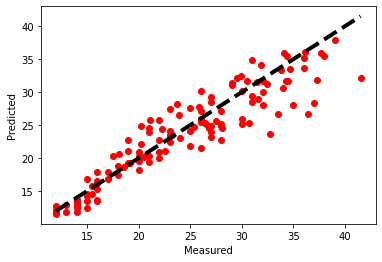

In [74]:
# predicting using the test data
MPG_y = y_test.mpg
plt.plot(y_test, np.exp(model_DS1_Final.predict(X_test)), 'ro')
plt.plot([MPG_y.min(), MPG_y.max()], [MPG_y.min(), MPG_y.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted');

### R^2 Value of the Test Data

In [75]:
#calculating the r^2 value of the test data
corr_matrix = np.corrcoef(y_test['mpg'], model_DS1_Final.predict(X_test))
corr = corr_matrix[0,1]
R_sq = corr**2
 
print("The R^2 value for the test data is:" + str(R_sq))

The R^2 value for the test data is:0.8360004167197157


### QQ Plot

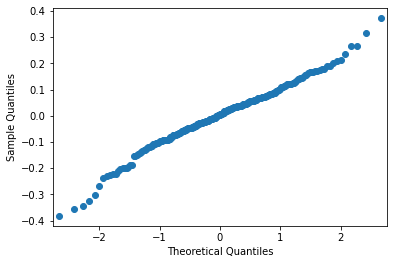

In [76]:
# QQ plot of the model residuals
sm.qqplot(model_DS1_Final.resid);

### Leverage vs Normalized Residuals

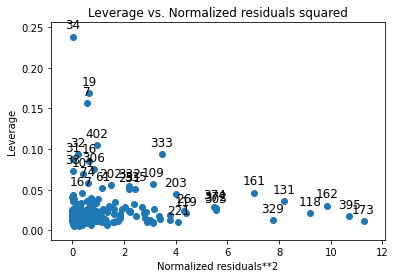

In [77]:
# Leverage plot to identigy high leverage datapoints
sm.graphics.plot_leverage_resid2(model_DS1_Final, alpha=0.05);

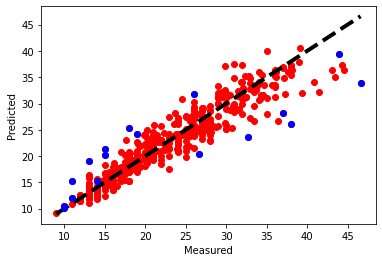

In [110]:
lev = [19, 32,31,74,109,372,327,340,329,161,131,118,173,119,162,395,402]
predicts = np.exp(model_DS1_Final.predict(X_1))
Y = y_1['mpg']

plt.plot(Y, predicts, 'ro');
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
plt.plot(Y[lev], predicts[lev], 'bo');
plt.xlabel('Measured')
plt.ylabel('Predicted');

### Variance Inflaction Factors

In [79]:
#VIF to determine how extensive the multicollinearity is
test = df.copy()
test['origin'] = test['origin'].map({'US':0, 'EU':1, 'AS':2})
X = test[['weight', 'model_year', 'horsepower', 'acceleration']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

        feature        VIF
0        weight  66.858723
1    model_year  91.254028
2    horsepower  55.837598
3  acceleration  66.320846


## Analysis of final model before eliminating terms

The model performed decently well. With a train / test split both the training and testing R^2 values were greater than 80%. Based on the plot of the predictions, however, the model appears to have issues overpredicting the MPG for higher MPG vehicles. The model overpredicts every vehicle over about 38 mpg's in the dataset. The QQ plot shows that there are issues at either end in the model. The middle of the qq plot is linear but the edges both have deviations. The residuals plot shows there are a considerable number of high leverage datapoints in the dataset impacting the model. The prediction plot with some of them highlighted shows many of these are in upper/lower regions where the model accuracy is an issue. 

The biggest issue with this model currently though is there is a good amount of multicollinearity occurring. All of the VIF values are well above the 5-10 threshold recommended in the Introduction to Statistical Learning textbook. Therefor terms are going to be reduced to hopefully eliminate this issue.

## Final Model After eliminating terms to reduce multicollinearity

The horsepower*acceleration term was removed to try and eliminate the multicollinearity issues. 

### Build Test/Train datasets / Train Model

In [80]:
# create X and y for test and train data
X_1 = df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']]
y_1 = df[['mpg']]

In [81]:
# split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.33)

Train = X_train.copy()
Train['mpg'] = y_train['mpg']

model_DS1_Final_lowmc = smf.ols(formula='np.log(mpg) ~ np.log(weight) + model_year', data=Train).fit()
model_DS1_Final_lowmc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     876.7
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          4.94e-116
Time:                        00:41:16   Log-Likelihood:                 175.22
No. Observations:                 262   AIC:                            -344.4
Df Residuals:                     259   BIC:                            -333.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.1765      0.309     26.491      0.000       7.569       8.784
np.log(weight)    -0.9533      0.028    -33.923      0.000      -1.009      -0.898
model_year         0.0330      0.002     15.294      0.000       0.029       0.037
==============================================================================
Omnibus:                        6.951   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.031   Jarque-Bera (JB):               11.362
Skew:                           0.014   Prob(JB):                      0.00341
Kurtosis:                       4.020   Cond. No.                     3.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Predict the MPG for the Test Dataset

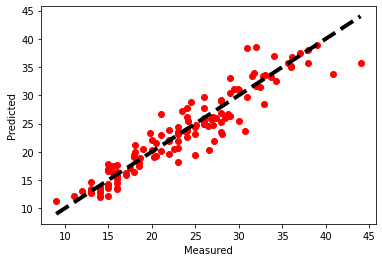

In [82]:
# plot the predictions on the test dataset
MPG_y = y_test.mpg
plt.plot(y_test, np.exp(model_DS1_Final_lowmc.predict(X_test)), 'ro')
plt.plot([MPG_y.min(), MPG_y.max()], [MPG_y.min(), MPG_y.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted');

### Calculate R^2 for Test Predictions

In [83]:
#calculate the r^2 value on the test data
corr_matrix = np.corrcoef(y_test['mpg'], model_DS1_Final_lowmc.predict(X_test))
corr = corr_matrix[0,1]
R_sq = corr**2
 
print("The R^2 value for the test data is:" + str(R_sq))

The R^2 value for the test data is:0.8760090263154213


### QQ Plot

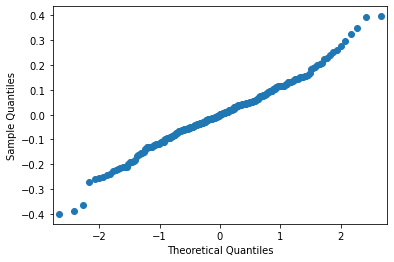

In [84]:
# generate the QQ plot
sm.qqplot(model_DS1_Final_lowmc.resid);

### Leverage vs. Normalized Residuals

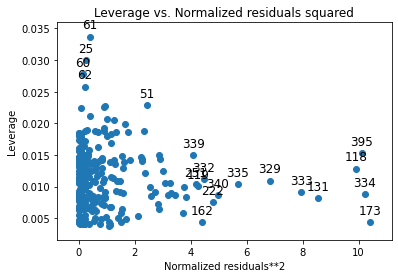

In [85]:
# plot the high leverate data points
sm.graphics.plot_leverage_resid2(model_DS1_Final_lowmc, alpha=0.05);

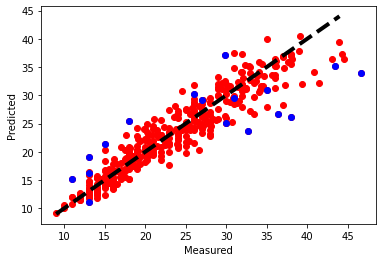

In [111]:
lev = [61,25,60,62,51,339,335,340,222,162,329,333,131,395,118,334,173]
predicts = np.exp(model_DS1_Final.predict(X_1))
Y= y_1['mpg']

plt.plot(Y, predicts, 'ro');
plt.plot([MPG_y.min(), MPG_y.max()], [MPG_y.min(), MPG_y.max()], 'k--', lw=4)
plt.plot(Y[lev], predicts[lev], 'bo');
plt.xlabel('Measured')
plt.ylabel('Predicted');

### Variance Inflation Factors

In [87]:
#Calculate the VIF terms
test = df.copy()
test['origin'] = test['origin'].map({'NA':0, 'EU':1, 'AS':2})
test['acceleration_horsepower'] = test['acceleration'] * test['horsepower']
X = test[['weight', 'model_year']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

      feature        VIF
0      weight  11.751992
1  model_year  11.751992


## Analysis of the model after removing terms

The model still preforms pretty well after removing the horsepower*acceleration term. The model achieved above 80 R^2 on both the test and train datasets. Looking at the prediction vs measured plot the model still struggles to accruately predict the higher MPGs and is still overshooting everything above ~40 MPG. Additionally the QQ plot shows there are some issues on the edges with linearity. Looking at the normalized residuals vs leverage plot there are a ton of leverage and high residual datapoints in the model. These could probably be cleaned up to create a more robust model. 

The issue of multicollinearity still percists however. Even with the model reduced to only 2 terms the VIF is above the textbook recommended values of 5-10. I played around a bit and the only terms that keep the VIF below 5 are not statistically significant in the model. In order to keep the VIF terms below 5 the model would be log-log with just the weight term. For the purpose of this project we will keep the model as weight + model_year at this point even though issues with multicollinearity persist.

The main take away from this model is the most significant term is vehicle weight. The log of MPG is negatively related to the log of vehicle weight. Most of the dataset attributes are correlated so this significantly limits model development without overfit. Model year has an impact on the MPG however for this dataset the model year is correlated to the vehicle weight. 

# Model Development for Dataset #2

The exact same approach will be utilized for the Dataset #2 model. Basedon the data exploration above the curb_weight, engine_size, and horsepower terms appear to be expontial or logarithmic in relation to MPG. Each will be modeled individually to determine the best model.

In [88]:
# renamed each column with a "-" to prevent issues in patys model function
# the "-" creates and issue in the statmodel formula. Every "-" was changed to "_" 
df2 = df2.rename(columns={"fuel-type": "fuel_type", 'num-of-doors':'num_of_doors', 'body-style':'body_style', 'drive-wheels':'drive_wheels', 'engine-location':'engine_location', 'wheel-base':'wheel_base', 'curb-weight':'curb_weight', 'engine-type':'engine_type', 'num-of-cylinders':'num_of_cylinders', 'engine-size':'engine_size', 'fuel-system':'fuel_system', 'compression-ratio':'compression_ratio', 'peak-rpm':'peak_rpm', 'city-mpg':'city_mpg', 'highway-mpg':'highway_mpg'})
df2.head()

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [89]:
# Develop the models 
model_dataset2_lincheck_01 = smf.ols(formula='city_mpg~curb_weight', data=df2).fit()
model_dataset2_lincheck_02 = smf.ols(formula='city_mpg~engine_size', data=df2).fit()
model_dataset2_lincheck_03 = smf.ols(formula='city_mpg~horsepower', data=df2).fit()

model_dataset2_expcheck_01 = smf.ols(formula='city_mpg~curb_weight + np.power(curb_weight,2)', data=df2).fit()
model_dataset2_expcheck_02 = smf.ols(formula='city_mpg~engine_size + np.power(engine_size,2)', data=df2).fit()
model_dataset2_expcheck_03 = smf.ols(formula='city_mpg~horsepower + np.power(horsepower,2)', data=df2).fit()

model_dataset2_logcheck_01 = smf.ols(formula='city_mpg~np.log(curb_weight)', data=df2).fit()
model_dataset2_logcheck_02 = smf.ols(formula='city_mpg~np.log(engine_size)', data=df2).fit()
model_dataset2_logcheck_03 = smf.ols(formula='city_mpg~np.log(horsepower)', data=df2).fit()

model_dataset2_loglogcheck_01 = smf.ols(formula='np.log(city_mpg) ~ np.log(curb_weight)', data=df2).fit()
model_dataset2_loglogcheck_02 = smf.ols(formula='np.log(city_mpg) ~ np.log(engine_size)', data=df2).fit()
model_dataset2_loglogcheck_03 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower)', data=df2).fit()

In [90]:
# output the R^2 values
L = [model_dataset2_lincheck_01,model_dataset2_lincheck_02,model_dataset2_lincheck_03]
L2 = [model_dataset2_expcheck_01,model_dataset2_expcheck_02,model_dataset2_expcheck_03]
L3 = [model_dataset2_logcheck_01,model_dataset2_logcheck_02,model_dataset2_logcheck_03]
L4 = [model_dataset2_loglogcheck_01,model_dataset2_loglogcheck_02,model_dataset2_loglogcheck_03]

print("linear models:")
for model in L:
    print (model.rsquared_adj)

print("")
print("exponential models:")
for model in L2:
    print (model.rsquared_adj)
    
print("")
print("Linear - logarithmic models:")
for model in L3:
    print (model.rsquared_adj)

print("")
print("Logarithmic - logarithmic models:")
for model in L4:
    print (model.rsquared_adj)

linear models:
0.6028470596309253
0.5106487333945702
0.6933174100345838

exponential models:
0.6776948304106092
0.6172508652093618
0.7919868836935816

Linear - logarithmic models:
0.6482721396571722
0.6043647564711114
0.786184618531703

Logarithmic - logarithmic models:
0.6836323952321616
0.6777859618686928
0.8389426869193435


Based on the R^2 values it looks like again the best fit for all 3 terms is the log-log model. Plots of each model are shown below to verify these fits.

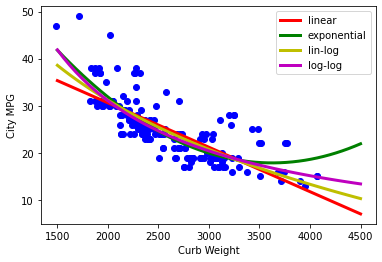

In [91]:
# Plot for curb weight models
plt.plot(df2.curb_weight, df2.city_mpg, 'bo');
xticks = np.linspace(1500,4500)
plt.plot(xticks, model_dataset2_lincheck_01.params[0] + xticks * model_dataset2_lincheck_01.params[1], 'r', lw=3, label='linear');
plt.plot(xticks, model_dataset2_expcheck_01.params[0] + xticks * model_dataset2_expcheck_01.params[1] + xticks*xticks*model_dataset2_expcheck_01.params[2], 'g', lw=3, label='exponential');
plt.plot(xticks, model_dataset2_logcheck_01.params[0] + np.log(xticks) * model_dataset2_logcheck_01.params[1], 'y', lw=3, label='lin-log');
plt.plot(xticks, np.exp(model_dataset2_loglogcheck_01.params[0] + np.log(xticks) * model_dataset2_loglogcheck_01.params[1]), 'm', lw=3, label='log-log');
plt.xlabel('Curb Weight');
plt.ylabel('City MPG');
plt.legend()

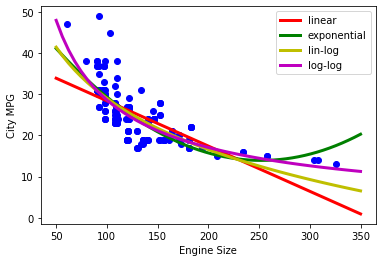

In [92]:
# Plot for curb engine size models
plt.plot(df2.engine_size, df2.city_mpg, 'bo');
xticks = np.linspace(50,350)
plt.plot(xticks, model_dataset2_lincheck_02.params[0] + xticks * model_dataset2_lincheck_02.params[1], 'r', lw=3, label='linear');
plt.plot(xticks, model_dataset2_expcheck_02.params[0] + xticks * model_dataset2_expcheck_02.params[1] + xticks*xticks*model_dataset2_expcheck_02.params[2], 'g', lw=3, label='exponential');
plt.plot(xticks, model_dataset2_logcheck_02.params[0] + np.log(xticks) * model_dataset2_logcheck_02.params[1], 'y', lw=3, label='lin-log');
plt.plot(xticks, np.exp(model_dataset2_loglogcheck_02.params[0] + np.log(xticks) * model_dataset2_loglogcheck_02.params[1]), 'm', lw=3, label='log-log');
plt.xlabel('Engine Size');
plt.ylabel('City MPG');
plt.legend()

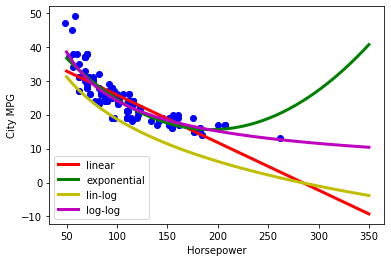

In [93]:
# Plot for horsepower models
plt.plot(df2.horsepower, df2.city_mpg, 'bo');
xticks = np.linspace(50,350)
plt.plot(xticks, model_dataset2_lincheck_03.params[0] + xticks * model_dataset2_lincheck_03.params[1], 'r', lw=3, label='linear');
plt.plot(xticks, model_dataset2_expcheck_03.params[0] + xticks * model_dataset2_expcheck_03.params[1] + xticks*xticks*model_dataset2_expcheck_03.params[2], 'g', lw=3, label='exponential');
plt.plot(xticks, model_dataset2_logcheck_03.params[0] + np.log(xticks) * model_dataset2_logcheck_02.params[1], 'y', lw=3, label='lin-log');
plt.plot(xticks, np.exp(model_dataset2_loglogcheck_03.params[0] + np.log(xticks) * model_dataset2_loglogcheck_03.params[1]), 'm', lw=3, label='log-log');
plt.xlabel('Horsepower');
plt.ylabel('City MPG');
plt.legend()

## Forward Stepwise Selection

Same as for dataset 1 forward stepwise selection will be utilzed to build the model. Each iteration is shown below

In [94]:
#Iteration 1
model_dataset2_fss01_01 = smf.ols(formula='city_mpg ~ make', data=df2).fit()
model_dataset2_fss01_02 = smf.ols(formula='city_mpg ~ fuel_type', data=df2).fit()
model_dataset2_fss01_03 = smf.ols(formula='city_mpg ~ aspiration', data=df2).fit()
model_dataset2_fss01_04 = smf.ols(formula='city_mpg ~ num_of_doors', data=df2).fit()
model_dataset2_fss01_05 = smf.ols(formula='city_mpg ~ body_style', data=df2).fit()
model_dataset2_fss01_06 = smf.ols(formula='city_mpg ~ drive_wheels', data=df2).fit()
model_dataset2_fss01_07 = smf.ols(formula='city_mpg ~ wheel_base', data=df2).fit()
model_dataset2_fss01_08 = smf.ols(formula='city_mpg ~ length', data=df2).fit()
model_dataset2_fss01_09 = smf.ols(formula='city_mpg ~ width', data=df2).fit()
model_dataset2_fss01_10 = smf.ols(formula='city_mpg ~ height', data=df2).fit()
model_dataset2_fss01_11 = smf.ols(formula='np.log(city_mpg) ~ np.log(curb_weight)', data=df2).fit()
model_dataset2_fss01_12 = smf.ols(formula='city_mpg ~ engine_type', data=df2).fit()
model_dataset2_fss01_13 = smf.ols(formula='city_mpg ~ num_of_cylinders', data=df2).fit()
model_dataset2_fss01_14 = smf.ols(formula='np.log(city_mpg) ~ np.log(engine_size)', data=df2).fit()
model_dataset2_fss01_15 = smf.ols(formula='city_mpg ~ fuel_system', data=df2).fit()
model_dataset2_fss01_16 = smf.ols(formula='city_mpg ~ bore', data=df2).fit()
model_dataset2_fss01_17 = smf.ols(formula='city_mpg ~ stroke', data=df2).fit()
model_dataset2_fss01_18 = smf.ols(formula='city_mpg ~ compression_ratio', data=df2).fit()
model_dataset2_fss01_19 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower)', data=df2).fit()
model_dataset2_fss01_20 = smf.ols(formula='city_mpg ~ peak_rpm', data=df2).fit()
model_dataset2_fss01_21 = smf.ols(formula='city_mpg ~ price', data=df2).fit()



Lmodels = [model_dataset2_fss01_01, model_dataset2_fss01_02, model_dataset2_fss01_03, model_dataset2_fss01_04, model_dataset2_fss01_05, model_dataset2_fss01_06, model_dataset2_fss01_07, model_dataset2_fss01_08,
          model_dataset2_fss01_09, model_dataset2_fss01_10, model_dataset2_fss01_11, model_dataset2_fss01_12, model_dataset2_fss01_13, model_dataset2_fss01_14, model_dataset2_fss01_15, model_dataset2_fss01_16,
          model_dataset2_fss01_17, model_dataset2_fss01_18, model_dataset2_fss01_19, model_dataset2_fss01_20, model_dataset2_fss01_21]

Lnames = ['make', 'fuel_type', 'aspiration', 'num_of_doors', 'body_style',
       'drive_wheels', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'engine_type', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore', 'stroke', 'compression_ratio',
       'horsepower', 'peak_rpm', 'price']

for model,name in zip(Lmodels, Lnames):
    print(name + " R squared: " + str(model.rsquared_adj))

make R squared: 0.40394154830989515
fuel_type R squared: 0.05382804841000399
aspiration R squared: 0.03726861475619314
num_of_doors R squared: -0.0005208718547538016
body_style R squared: 0.0493303806089288
drive_wheels R squared: 0.2975151552770129
wheel_base R squared: 0.25061651047231215
length R squared: 0.4903498056363995
width R squared: 0.4288759741542417
height R squared: 0.007187082144100798
curb_weight R squared: 0.6836323952321616
engine_type R squared: 0.18594413204419236
num_of_cylinders R squared: 0.3606045322832375
engine_size R squared: 0.6777859618686928
fuel_system R squared: 0.5247838045438119
bore R squared: 0.3583027043775614
stroke R squared: -0.004254079640616082
compression_ratio R squared: 0.0942862869156692
horsepower R squared: 0.8389426869193435
peak_rpm R squared: -0.0014911375937609606
price R squared: 0.4966875698291232


In [95]:
#Select the best model
model_dataset2_fss01_19.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(city_mpg)   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1001.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           7.05e-78
Time:                        00:41:18   Log-Likelihood:                 170.63
No. Observations:                 193   AIC:                            -337.3
Df Residuals:                     191   BIC:                            -330.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.2817      0.098     64.335      0.000       6.089       6.474
np.log(horsepower)    -0.6728      0.021    -31.641      0.000      -0.715      -0.631
==============================================================================
Omnibus:                        4.784   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                5.548
Skew:                          -0.174   Prob(JB):                       0.0624
Kurtosis:                       3.754   Cond. No.                         64.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
#Iteration 2
model_dataset2_fss02_01 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make', data=df2).fit()
model_dataset2_fss02_02 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + fuel_type', data=df2).fit()
model_dataset2_fss02_03 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + aspiration', data=df2).fit()
model_dataset2_fss02_04 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + num_of_doors', data=df2).fit()
model_dataset2_fss02_05 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + body_style', data=df2).fit()
model_dataset2_fss02_06 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + drive_wheels', data=df2).fit()
model_dataset2_fss02_07 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + wheel_base', data=df2).fit()
model_dataset2_fss02_08 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + length', data=df2).fit()
model_dataset2_fss02_09 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + width', data=df2).fit()
model_dataset2_fss02_10 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + height', data=df2).fit()
model_dataset2_fss02_11 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + np.log(curb_weight)', data=df2).fit()
model_dataset2_fss02_12 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + engine_type', data=df2).fit()
model_dataset2_fss02_13 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + num_of_cylinders', data=df2).fit()
model_dataset2_fss02_14 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + np.log(engine_size)', data=df2).fit()
model_dataset2_fss02_15 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + fuel_system', data=df2).fit()
model_dataset2_fss02_16 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + bore', data=df2).fit()
model_dataset2_fss02_17 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + stroke', data=df2).fit()
model_dataset2_fss02_18 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + compression_ratio', data=df2).fit()
model_dataset2_fss02_19 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + peak_rpm', data=df2).fit()
model_dataset2_fss02_20 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + price', data=df2).fit()



Lmodels = [model_dataset2_fss02_01, model_dataset2_fss02_02, model_dataset2_fss02_03, model_dataset2_fss02_04, model_dataset2_fss02_05, model_dataset2_fss02_06, model_dataset2_fss02_07,
           model_dataset2_fss02_08, model_dataset2_fss02_09, model_dataset2_fss02_10, model_dataset2_fss02_11, model_dataset2_fss02_12, model_dataset2_fss02_13, model_dataset2_fss02_14,
           model_dataset2_fss02_15, model_dataset2_fss02_16, model_dataset2_fss02_17, model_dataset2_fss02_18, model_dataset2_fss02_19, model_dataset2_fss02_20]

Lnames = ['make', 'fuel_type', 'aspiration', 'num_of_doors', 'body_style',
       'drive_wheels', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'engine_type', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore', 'stroke', 'compression_ratio',
          'peak_rpm', 'price']

for model,name in zip(Lmodels, Lnames):
    print(name + " R squared: " + str(model.rsquared_adj))

make R squared: 0.8757357864266615
fuel_type R squared: 0.844396328127277
aspiration R squared: 0.8430672924247086
num_of_doors R squared: 0.8481582641390211
body_style R squared: 0.8505041952144863
drive_wheels R squared: 0.8482865929718221
wheel_base R squared: 0.8562135075308482
length R squared: 0.8636545666346711
width R squared: 0.8519080738286922
height R squared: 0.8552669193762479
curb_weight R squared: 0.8643780179169106
engine_type R squared: 0.8437268911867108
num_of_cylinders R squared: 0.8508145219546425
engine_size R squared: 0.8428458672638279
fuel_system R squared: 0.8482490290872613
bore R squared: 0.8402204866745827
stroke R squared: 0.8445908098235414
compression_ratio R squared: 0.8476165471035639
peak_rpm R squared: 0.8393251543464877
price R squared: 0.8449662766616777


In [97]:
#Select the best model
model_dataset2_fss02_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(city_mpg)   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     65.43
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           2.14e-70
Time:                        00:41:18   Log-Likelihood:                 206.33
No. Observations:                 193   AIC:                            -368.7
Df Residuals:                     171   BIC:                            -296.9
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 6.0512      0.134     45.208      0.000       5.787       6.315
make[T.audi]             -0.1078      0.062     -1.726      0.086      -0.231       0.015
make[T.bmw]              -0.0064      0.060     -0.107      0.915      -0.124       0.112
make[T.chevrolet]         0.2582      0.074      3.478      0.001       0.112       0.405
make[T.dodge]             0.0538      0.061      0.886      0.377      -0.066       0.174
make[T.honda]             0.1036      0.058      1.796      0.074      -0.010       0.217
make[T.isuzu]            -0.0794      0.081     -0.978      0.329      -0.240       0.081
make[T.jaguar]           -0.0452      0.073     -0.618      0.537      -0.190       0.099
make[T.mazda]             0.0164      0.058      0.282      0.778      -0.098       0.131
make[T.mercedes-benz]    -0.0168      0.060     -0.281      0.779      -0.135       0.101
make[T.mercury]           0.1516      0.102      1.482      0.140      -0.050       0.354
make[T.mitsubishi]        0.0525      0.057      0.924      0.357      -0.060       0.165
make[T.nissan]            0.0729      0.055      1.314      0.191      -0.037       0.182
make[T.peugot]           -0.0564      0.058     -0.976      0.330      -0.170       0.058
make[T.plymouth]          0.0551      0.062      0.892      0.374      -0.067       0.177
make[T.porsche]           0.1158      0.068      1.697      0.092      -0.019       0.251
make[T.saab]              0.0042      0.062      0.068      0.946      -0.119       0.127
make[T.subaru]            0.0192      0.058      0.333      0.740      -0.095       0.133
make[T.toyota]            0.0702      0.054      1.300      0.195      -0.036       0.177
make[T.volkswagen]        0.0393      0.058      0.676      0.500      -0.075       0.154
make[T.volvo]             0.0441      0.057      0.766      0.445      -0.069       0.158
np.log(horsepower)       -0.6309      0.026    -24.561      0.000      -0.682      -0.580
==============================================================================
Omnibus:                        9.147   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               12.640
Skew:                           0.302   Prob(JB):                      0.00180
Kurtosis:                       4.099   Cond. No.                         179.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
# Iteration 3
model_dataset2_fss03_01 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + fuel_type', data=df2).fit()
model_dataset2_fss03_02 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + aspiration', data=df2).fit()
model_dataset2_fss03_03 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + num_of_doors', data=df2).fit()
model_dataset2_fss03_04 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + body_style', data=df2).fit()
model_dataset2_fss03_05 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + drive_wheels', data=df2).fit()
model_dataset2_fss03_06 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + wheel_base', data=df2).fit()
model_dataset2_fss03_07 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + length', data=df2).fit()
model_dataset2_fss03_08 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + width', data=df2).fit()
model_dataset2_fss03_09 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + height', data=df2).fit()
model_dataset2_fss03_10 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + np.log(curb_weight)', data=df2).fit()
model_dataset2_fss03_11 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + engine_type', data=df2).fit()
model_dataset2_fss03_12 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + num_of_cylinders', data=df2).fit()
model_dataset2_fss03_13 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + np.log(engine_size)', data=df2).fit()
model_dataset2_fss03_14 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + fuel_system', data=df2).fit()
model_dataset2_fss03_15 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + bore', data=df2).fit()
model_dataset2_fss03_16 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + stroke', data=df2).fit()
model_dataset2_fss03_17 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio', data=df2).fit()
model_dataset2_fss03_18 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + peak_rpm', data=df2).fit()
model_dataset2_fss03_19 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + price', data=df2).fit()



Lmodels = [model_dataset2_fss03_01, model_dataset2_fss03_02, model_dataset2_fss03_03, model_dataset2_fss03_04, model_dataset2_fss03_05, model_dataset2_fss03_06, model_dataset2_fss03_07,
           model_dataset2_fss03_08, model_dataset2_fss03_09, model_dataset2_fss03_10, model_dataset2_fss03_11, model_dataset2_fss03_12, model_dataset2_fss03_13, model_dataset2_fss03_14,
           model_dataset2_fss03_15, model_dataset2_fss03_16, model_dataset2_fss03_17, model_dataset2_fss03_18, model_dataset2_fss03_19]

Lnames = ['fuel_type', 'aspiration', 'num_of_doors', 'body_style',
       'drive_wheels', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'engine_type', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore', 'stroke', 'compression_ratio',
          'peak_rpm', 'price']

for model,name in zip(Lmodels, Lnames):
    print(name + " R squared: " + str(model.rsquared_adj))

fuel_type R squared: 0.9023394787950377
aspiration R squared: 0.8879327365758407
num_of_doors R squared: 0.8773160677886942
body_style R squared: 0.8794407166041728
drive_wheels R squared: 0.8870760809283821
wheel_base R squared: 0.8779057446557443
length R squared: 0.878772149124631
width R squared: 0.8750154470022399
height R squared: 0.883545324806081
curb_weight R squared: 0.8808992898482132
engine_type R squared: 0.8785090285193954
num_of_cylinders R squared: 0.8857632638550641
engine_size R squared: 0.8750430931893286
fuel_system R squared: 0.9015126680507547
bore R squared: 0.8750963043752749
stroke R squared: 0.8851763111023366
compression_ratio R squared: 0.9058163554866351
peak_rpm R squared: 0.8775285860820548
price R squared: 0.8763910260241401


In [99]:
#Select the best model
model_dataset2_fss03_17.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(city_mpg)   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     84.94
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           8.44e-80
Time:                        00:41:18   Log-Likelihood:                 233.64
No. Observations:                 193   AIC:                            -421.3
Df Residuals:                     170   BIC:                            -346.2
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.6082      0.131     42.875      0.000       5.350       5.866
make[T.audi]             -0.0975      0.054     -1.792      0.075      -0.205       0.010
make[T.bmw]              -0.0068      0.052     -0.130      0.896      -0.110       0.096
make[T.chevrolet]         0.2985      0.065      4.602      0.000       0.170       0.427
make[T.dodge]             0.0855      0.053      1.613      0.109      -0.019       0.190
make[T.honda]             0.1312      0.050      2.607      0.010       0.032       0.231
make[T.isuzu]            -0.0509      0.071     -0.719      0.473      -0.191       0.089
make[T.jaguar]           -0.0812      0.064     -1.272      0.205      -0.207       0.045
make[T.mazda]             0.0371      0.051      0.732      0.465      -0.063       0.137
make[T.mercedes-benz]    -0.1012      0.053     -1.897      0.059      -0.207       0.004
make[T.mercury]           0.1407      0.089      1.580      0.116      -0.035       0.317
make[T.mitsubishi]        0.0787      0.050      1.589      0.114      -0.019       0.177
make[T.nissan]            0.0816      0.048      1.688      0.093      -0.014       0.177
make[T.peugot]           -0.1048      0.051     -2.066      0.040      -0.205      -0.005
make[T.plymouth]          0.0863      0.054      1.600      0.111      -0.020       0.193
make[T.porsche]           0.0807      0.060      1.354      0.178      -0.037       0.198
make[T.saab]              0.0012      0.054      0.022      0.982      -0.106       0.108
make[T.subaru]            0.0469      0.050      0.931      0.353      -0.053       0.146
make[T.toyota]            0.0767      0.047      1.631      0.105      -0.016       0.170
make[T.volkswagen]        0.0110      0.051      0.218      0.828      -0.089       0.111
make[T.volvo]             0.0271      0.050      0.540      0.590      -0.072       0.126
np.log(horsepower)       -0.5627      0.024    -23.289      0.000      -0.610      -0.515
compression_ratio         0.0127      0.002      7.458      0.000       0.009       0.016
==============================================================================
Omnibus:                       18.814   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.408
Skew:                           0.442   Prob(JB):                     2.77e-09
Kurtosis:                       5.030   Cond. No.                         450.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
# Iteration 4
model_dataset2_fss04_01 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + fuel_type', data=df2).fit()
model_dataset2_fss04_02 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + aspiration', data=df2).fit()
model_dataset2_fss04_03 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + num_of_doors', data=df2).fit()
model_dataset2_fss04_04 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + body_style', data=df2).fit()
model_dataset2_fss04_05 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + drive_wheels', data=df2).fit()
model_dataset2_fss04_06 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + wheel_base', data=df2).fit()
model_dataset2_fss04_07 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + length', data=df2).fit()
model_dataset2_fss04_08 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + width', data=df2).fit()
model_dataset2_fss04_09 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + height', data=df2).fit()
model_dataset2_fss04_10 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight)', data=df2).fit()
model_dataset2_fss04_11 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + engine_type', data=df2).fit()
model_dataset2_fss04_12 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + num_of_cylinders', data=df2).fit()
model_dataset2_fss04_13 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(engine_size)', data=df2).fit()
model_dataset2_fss04_14 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + fuel_system', data=df2).fit()
model_dataset2_fss04_15 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + bore', data=df2).fit()
model_dataset2_fss04_16 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + stroke', data=df2).fit()
model_dataset2_fss04_17 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + peak_rpm', data=df2).fit()
model_dataset2_fss04_18 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + price', data=df2).fit()



Lmodels = [model_dataset2_fss04_01, model_dataset2_fss04_02, model_dataset2_fss04_03, model_dataset2_fss04_04, model_dataset2_fss04_05, model_dataset2_fss04_06, model_dataset2_fss04_07,
           model_dataset2_fss04_08, model_dataset2_fss04_09, model_dataset2_fss04_10, model_dataset2_fss04_11, model_dataset2_fss04_12, model_dataset2_fss04_13, model_dataset2_fss04_14,
           model_dataset2_fss04_15, model_dataset2_fss04_16, model_dataset2_fss04_17, model_dataset2_fss04_18]

Lnames = ['fuel_type', 'aspiration', 'num_of_doors', 'body_style',
       'drive_wheels', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'engine_type', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore', 'stroke',
          'peak_rpm', 'price']

for model,name in zip(Lmodels, Lnames):
    print(name + " R squared: " + str(model.rsquared_adj))

fuel_type R squared: 0.9083153220951768
aspiration R squared: 0.9061632127830141
num_of_doors R squared: 0.908669290029463
body_style R squared: 0.9094596818332656
drive_wheels R squared: 0.9128091501946873
wheel_base R squared: 0.9132477840438488
length R squared: 0.9151807894985449
width R squared: 0.9081027537458514
height R squared: 0.9131933977312969
curb_weight R squared: 0.9353416152120049
engine_type R squared: 0.907268526773595
num_of_cylinders R squared: 0.9090721573293429
engine_size R squared: 0.9109106486199413
fuel_system R squared: 0.9068749262875885
bore R squared: 0.9058015571323504
stroke R squared: 0.9062775729642284
peak_rpm R squared: 0.905653081365171
price R squared: 0.9112828461799088


In [101]:
# Select the best model
model_dataset2_fss04_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(city_mpg)   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     121.8
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.01e-92
Time:                        00:41:18   Log-Likelihood:                 270.51
No. Observations:                 193   AIC:                            -493.0
Df Residuals:                     169   BIC:                            -414.7
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.1583      0.415     22.080      0.000       8.340       9.977
make[T.audi]             -0.0474      0.045     -1.043      0.298      -0.137       0.042
make[T.bmw]               0.0326      0.043      0.751      0.454      -0.053       0.118
make[T.chevrolet]         0.2261      0.054      4.159      0.000       0.119       0.333
make[T.dodge]             0.0663      0.044      1.508      0.133      -0.021       0.153
make[T.honda]             0.1037      0.042      2.479      0.014       0.021       0.186
make[T.isuzu]             0.0292      0.059      0.491      0.624      -0.088       0.146
make[T.jaguar]            0.0504      0.055      0.918      0.360      -0.058       0.159
make[T.mazda]             0.0510      0.042      1.214      0.227      -0.032       0.134
make[T.mercedes-benz]     0.0316      0.047      0.677      0.499      -0.061       0.124
make[T.mercury]           0.1150      0.074      1.557      0.121      -0.031       0.261
make[T.mitsubishi]        0.0723      0.041      1.760      0.080      -0.009       0.153
make[T.nissan]            0.0780      0.040      1.949      0.053      -0.001       0.157
make[T.peugot]            0.0484      0.045      1.064      0.289      -0.041       0.138
make[T.plymouth]          0.0827      0.045      1.850      0.066      -0.006       0.171
make[T.porsche]          -0.0049      0.050     -0.096      0.923      -0.104       0.095
make[T.saab]              0.0232      0.045      0.514      0.608      -0.066       0.112
make[T.subaru]            0.0663      0.042      1.584      0.115      -0.016       0.149
make[T.toyota]            0.1075      0.039      2.748      0.007       0.030       0.185
make[T.volkswagen]        0.0283      0.042      0.673      0.502      -0.055       0.111
make[T.volvo]             0.1020      0.042      2.407      0.017       0.018       0.186
np.log(horsepower)       -0.2928      0.036     -8.038      0.000      -0.365      -0.221
compression_ratio         0.0189      0.002     12.006      0.000       0.016       0.022
np.log(curb_weight)      -0.6229      0.070     -8.867      0.000      -0.762      -0.484
==============================================================================
Omnibus:                       26.430   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.716
Skew:                           0.581   Prob(JB):                     8.85e-15
Kurtosis:                       5.588   Cond. No.                     1.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+03. This might indicate that there are

Based on Note 2 in the summary output for the best model it is likely we have no introduced enough terms Multicollinearity is an issue. We will continue to add terms until they are no longer statistically relevant. We will remove terms to reduce multicollinearity at the end.

In [102]:
#Iteration #5
model_dataset2_fss05_01 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + fuel_type', data=df2).fit()
model_dataset2_fss05_02 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + aspiration', data=df2).fit()
model_dataset2_fss05_03 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + num_of_doors', data=df2).fit()
model_dataset2_fss05_04 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + body_style', data=df2).fit()
model_dataset2_fss05_05 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + drive_wheels', data=df2).fit()
model_dataset2_fss05_06 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + wheel_base', data=df2).fit()
model_dataset2_fss05_07 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + length', data=df2).fit()
model_dataset2_fss05_08 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + width', data=df2).fit()
model_dataset2_fss05_09 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + height', data=df2).fit()
model_dataset2_fss05_10 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + engine_type', data=df2).fit()
model_dataset2_fss05_11 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + num_of_cylinders', data=df2).fit()
model_dataset2_fss05_12 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + np.log(engine_size)', data=df2).fit()
model_dataset2_fss05_13 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + fuel_system', data=df2).fit()
model_dataset2_fss05_14 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + bore', data=df2).fit()
model_dataset2_fss05_15 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke', data=df2).fit()
model_dataset2_fss05_16 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + peak_rpm', data=df2).fit()
model_dataset2_fss05_17 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + price', data=df2).fit()



Lmodels = [model_dataset2_fss05_01, model_dataset2_fss05_02, model_dataset2_fss05_03, model_dataset2_fss05_04, model_dataset2_fss05_05, model_dataset2_fss05_06, model_dataset2_fss05_07,
           model_dataset2_fss05_08, model_dataset2_fss05_09, model_dataset2_fss05_10, model_dataset2_fss05_11, model_dataset2_fss05_12, model_dataset2_fss05_13, model_dataset2_fss05_14,
           model_dataset2_fss05_15, model_dataset2_fss05_16, model_dataset2_fss05_17]

Lnames = ['fuel_type', 'aspiration', 'num_of_doors', 'body_style',
       'drive_wheels', 'wheel_base', 'length', 'width',
       'height', 'engine_type', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore', 'stroke',
          'peak_rpm', 'price']

for model,name in zip(Lmodels, Lnames):
    print(name + " R squared: " + str(model.rsquared_adj))

fuel_type R squared: 0.935978784904915
aspiration R squared: 0.9349702970486842
num_of_doors R squared: 0.9349588321820209
body_style R squared: 0.9340520600671585
drive_wheels R squared: 0.9358325806873583
wheel_base R squared: 0.9351014418035388
length R squared: 0.9350868174170537
width R squared: 0.9355679331136236
height R squared: 0.9351582717619359
engine_type R squared: 0.934903885880974
num_of_cylinders R squared: 0.9363300529061704
engine_size R squared: 0.9351296370155865
fuel_system R squared: 0.9352810968316811
bore R squared: 0.9352425396049034
stroke R squared: 0.9380280675580364
peak_rpm R squared: 0.9363489767317313
price R squared: 0.9353849864768556


In [103]:
#Select the best model
model_dataset2_fss05_15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(city_mpg)   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     122.1
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           2.01e-93
Time:                        00:41:18   Log-Likelihood:                 275.18
No. Observations:                 193   AIC:                            -500.4
Df Residuals:                     168   BIC:                            -418.8
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.2591      0.408     22.718      0.000       8.454      10.064
make[T.audi]             -0.0787      0.046     -1.721      0.087      -0.169       0.012
make[T.bmw]               0.0208      0.043      0.487      0.627      -0.063       0.105
make[T.chevrolet]         0.1957      0.054      3.608      0.000       0.089       0.303
make[T.dodge]             0.0256      0.045      0.564      0.574      -0.064       0.115
make[T.honda]             0.0560      0.044      1.269      0.206      -0.031       0.143
make[T.isuzu]             0.0024      0.059      0.042      0.967      -0.114       0.119
make[T.jaguar]            0.0190      0.055      0.345      0.730      -0.089       0.127
make[T.mazda]             0.0173      0.043      0.404      0.686      -0.067       0.102
make[T.mercedes-benz]     0.0191      0.046      0.417      0.677      -0.071       0.110
make[T.mercury]           0.1097      0.072      1.517      0.131      -0.033       0.253
make[T.mitsubishi]        0.0277      0.043      0.643      0.521      -0.057       0.113
make[T.nissan]            0.0471      0.041      1.158      0.249      -0.033       0.127
make[T.peugot]            0.0433      0.045      0.973      0.332      -0.045       0.131
make[T.plymouth]          0.0422      0.046      0.918      0.360      -0.049       0.133
make[T.porsche]           0.0033      0.049      0.067      0.947      -0.094       0.101
make[T.saab]              0.0273      0.044      0.619      0.537      -0.060       0.115
make[T.subaru]            0.0785      0.041      1.906      0.058      -0.003       0.160
make[T.toyota]            0.0810      0.039      2.055      0.041       0.003       0.159
make[T.volkswagen]       -0.0054      0.043     -0.125      0.900      -0.090       0.079
make[T.volvo]             0.0943      0.042      2.268      0.025       0.012       0.176
np.log(horsepower)       -0.3086      0.036     -8.553      0.000      -0.380      -0.237
compression_ratio         0.0174      0.002     10.646      0.000       0.014       0.021
np.log(curb_weight)      -0.6493      0.069     -9.359      0.000      -0.786      -0.512
stroke                    0.0670      0.023      2.885      0.004       0.021       0.113
==============================================================================
Omnibus:                       30.498   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.704
Skew:                           0.660   Prob(JB):                     8.12e-18
Kurtosis:                       5.837   Cond. No.                     1.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly 

In [104]:
#Iteration #6 
model_dataset2_fss06_01 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type', data=df2).fit()
model_dataset2_fss06_02 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + aspiration', data=df2).fit()
model_dataset2_fss06_03 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + num_of_doors', data=df2).fit()
model_dataset2_fss06_04 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + body_style', data=df2).fit()
model_dataset2_fss06_05 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + drive_wheels', data=df2).fit()
model_dataset2_fss06_06 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + wheel_base', data=df2).fit()
model_dataset2_fss06_07 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + length', data=df2).fit()
model_dataset2_fss06_08 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + width', data=df2).fit()
model_dataset2_fss06_09 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + height', data=df2).fit()
model_dataset2_fss06_10 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + engine_type', data=df2).fit()
model_dataset2_fss06_11 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + num_of_cylinders', data=df2).fit()
model_dataset2_fss06_12 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + np.log(engine_size)', data=df2).fit()
model_dataset2_fss06_13 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_system', data=df2).fit()
model_dataset2_fss06_14 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + bore', data=df2).fit()
model_dataset2_fss06_15 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + peak_rpm', data=df2).fit()
model_dataset2_fss06_16 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + price', data=df2).fit()

Lmodels = [model_dataset2_fss06_01, model_dataset2_fss06_02, model_dataset2_fss06_03, model_dataset2_fss06_04, model_dataset2_fss06_05, model_dataset2_fss06_06, model_dataset2_fss06_07,
           model_dataset2_fss06_08, model_dataset2_fss06_09, model_dataset2_fss06_10, model_dataset2_fss06_11, model_dataset2_fss06_12, model_dataset2_fss06_13, model_dataset2_fss06_14,
           model_dataset2_fss06_15, model_dataset2_fss06_16]

Lnames = ['fuel_type', 'aspiration', 'num_of_doors', 'body_style',
       'drive_wheels', 'wheel_base', 'length', 'width',
       'height', 'engine_type', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore',
          'peak_rpm', 'price']

for model,name in zip(Lmodels, Lnames):
    print(name + " R squared: " + str(model.rsquared_adj))

fuel_type R squared: 0.9413501794816808
aspiration R squared: 0.9378486535298417
num_of_doors R squared: 0.9376742499828248
body_style R squared: 0.9369767124750852
drive_wheels R squared: 0.9386354617899128
wheel_base R squared: 0.9382123095187322
length R squared: 0.9376742794343839
width R squared: 0.9381951322161336
height R squared: 0.9382439450893489
engine_type R squared: 0.9371680114474517
num_of_cylinders R squared: 0.9380513221146736
engine_size R squared: 0.9376756766056611
fuel_system R squared: 0.9408019944129705
bore R squared: 0.9376781597059026
peak_rpm R squared: 0.9380591454150328
price R squared: 0.9378717580353901


In [105]:
# Select the best model
model_dataset2_fss06_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(city_mpg)   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     124.3
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.42e-94
Time:                        00:41:19   Log-Likelihood:                 281.07
No. Observations:                 193   AIC:                            -510.1
Df Residuals:                     167   BIC:                            -425.3
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.2511      0.504     16.378      0.000       7.257       9.246
make[T.audi]             -0.0827      0.045     -1.857      0.065      -0.171       0.005
make[T.bmw]               0.0237      0.041      0.571      0.569      -0.058       0.106
make[T.chevrolet]         0.1883      0.053      3.564      0.000       0.084       0.293
make[T.dodge]             0.0271      0.044      0.614      0.540      -0.060       0.114
make[T.honda]             0.0408      0.043      0.945      0.346      -0.044       0.126
make[T.isuzu]             0.0020      0.057      0.036      0.972      -0.111       0.115
make[T.jaguar]           -0.0267      0.055     -0.483      0.630      -0.136       0.082
make[T.mazda]             0.0233      0.042      0.559      0.577      -0.059       0.106
make[T.mercedes-benz]     0.0287      0.045      0.642      0.522      -0.060       0.117
make[T.mercury]           0.1295      0.071      1.833      0.069      -0.010       0.269
make[T.mitsubishi]        0.0425      0.042      1.008      0.315      -0.041       0.126
make[T.nissan]            0.0388      0.040      0.980      0.329      -0.039       0.117
make[T.peugot]            0.0744      0.044      1.678      0.095      -0.013       0.162
make[T.plymouth]          0.0452      0.045      1.011      0.313      -0.043       0.133
make[T.porsche]          -0.0175      0.048     -0.362      0.718      -0.113       0.078
make[T.saab]              0.0216      0.043      0.502      0.616      -0.063       0.106
make[T.subaru]            0.1013      0.041      2.491      0.014       0.021       0.182
make[T.toyota]            0.0742      0.038      1.934      0.055      -0.002       0.150
make[T.volkswagen]       -0.0142      0.042     -0.341      0.733      -0.097       0.068
make[T.volvo]             0.0854      0.041      2.108      0.037       0.005       0.165
fuel_type[T.gas]          0.4290      0.132      3.243      0.001       0.168       0.690
np.log(horsepower)       -0.2990      0.035     -8.489      0.000      -0.369      -0.229
compression_ratio         0.0483      0.010      4.995      0.000       0.029       0.067
np.log(curb_weight)      -0.6296      0.068     -9.291      0.000      -0.763      -0.496
stroke                    0.1005      0.025      4.048      0.000       0.052       0.150
==============================================================================
Omnibus:                       35.661   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.463
Skew:                           0.736   Prob(JB):                     3.41e-23
Kurtosis:                       6.271   Cond. No.                     1.69e+03
==============================================================================

In [106]:
# Iteration #7
model_dataset2_fss07_01 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + aspiration', data=df2).fit()
model_dataset2_fss07_02 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + num_of_doors', data=df2).fit()
model_dataset2_fss07_03 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + body_style', data=df2).fit()
model_dataset2_fss07_04 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + drive_wheels', data=df2).fit()
model_dataset2_fss07_05 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + wheel_base', data=df2).fit()
model_dataset2_fss07_06 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + length', data=df2).fit()
model_dataset2_fss07_07 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + width', data=df2).fit()
model_dataset2_fss07_08 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + height', data=df2).fit()
model_dataset2_fss07_09 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + engine_type', data=df2).fit()
model_dataset2_fss07_10 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + num_of_cylinders', data=df2).fit()
model_dataset2_fss07_11 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + np.log(engine_size)',
                                  data=df2).fit()
model_dataset2_fss07_12 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + fuel_system', data=df2).fit()
model_dataset2_fss07_13 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + bore', data=df2).fit()
model_dataset2_fss07_14 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + peak_rpm', data=df2).fit()
model_dataset2_fss07_15 = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type + price', data=df2).fit()

Lmodels = [model_dataset2_fss07_01, model_dataset2_fss07_02, model_dataset2_fss07_03, model_dataset2_fss07_04, model_dataset2_fss07_05, model_dataset2_fss07_06, model_dataset2_fss07_07,
           model_dataset2_fss07_08, model_dataset2_fss07_09, model_dataset2_fss07_10, model_dataset2_fss07_11, model_dataset2_fss07_12, model_dataset2_fss07_13, model_dataset2_fss07_14,
           model_dataset2_fss07_15]

Lnames = ['aspiration', 'num_of_doors', 'body_style',
       'drive_wheels', 'wheel_base', 'length', 'width',
       'height', 'engine_type', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore',
          'peak_rpm', 'price']

for model,name in zip(Lmodels, Lnames):
    print(name + " R squared: " + str(model.rsquared_adj))

aspiration R squared: 0.9416324488043882
num_of_doors R squared: 0.9410079581810491
body_style R squared: 0.940715033119714
drive_wheels R squared: 0.9410191887111554
wheel_base R squared: 0.9419153336741405
length R squared: 0.941051249826422
width R squared: 0.9411421681492254
height R squared: 0.9412508771272733
engine_type R squared: 0.9404411612207589
num_of_cylinders R squared: 0.9413503267747052
engine_size R squared: 0.9411251574405769
fuel_system R squared: 0.9408019944129705
bore R squared: 0.9410323491442663
peak_rpm R squared: 0.9417452611075824
price R squared: 0.9411158168137926


In [107]:
# Select the best model
model_dataset2_fss07_04.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(city_mpg)   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     114.5
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.05e-92
Time:                        00:41:19   Log-Likelihood:                 281.69
No. Observations:                 193   AIC:                            -507.4
Df Residuals:                     165   BIC:                            -416.0
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.2350      0.525     15.683      0.000       7.198       9.272
make[T.audi]             -0.0685      0.049     -1.408      0.161      -0.165       0.028
make[T.bmw]               0.0226      0.042      0.543      0.588      -0.060       0.105
make[T.chevrolet]         0.1978      0.054      3.639      0.000       0.090       0.305
make[T.dodge]             0.0362      0.046      0.780      0.437      -0.055       0.128
make[T.honda]             0.0517      0.046      1.127      0.261      -0.039       0.142
make[T.isuzu]            -0.0048      0.058     -0.082      0.934      -0.119       0.110
make[T.jaguar]           -0.0225      0.056     -0.401      0.689      -0.133       0.088
make[T.mazda]             0.0285      0.043      0.664      0.508      -0.056       0.113
make[T.mercedes-benz]     0.0258      0.045      0.571      0.568      -0.063       0.115
make[T.mercury]           0.1315      0.071      1.855      0.065      -0.008       0.271
make[T.mitsubishi]        0.0516      0.045      1.146      0.253      -0.037       0.141
make[T.nissan]            0.0479      0.042      1.138      0.257      -0.035       0.131
make[T.peugot]            0.0649      0.045      1.428      0.155      -0.025       0.155
make[T.plymouth]          0.0520      0.046      1.125      0.262      -0.039       0.143
make[T.porsche]          -0.0082      0.050     -0.165      0.869      -0.106       0.090
make[T.saab]              0.0344      0.048      0.711      0.478      -0.061       0.130
make[T.subaru]            0.1173      0.044      2.656      0.009       0.030       0.205
make[T.toyota]            0.0794      0.039      2.028      0.044       0.002       0.157
make[T.volkswagen]       -0.0044      0.045     -0.099      0.922      -0.093       0.084
make[T.volvo]             0.0840      0.041      2.065      0.040       0.004       0.164
fuel_type[T.gas]          0.3866      0.139      2.776      0.006       0.112       0.661
drive_wheels[T.fwd]       0.0230      0.028      0.824      0.411      -0.032       0.078
drive_wheels[T.rwd]       0.0359      0.035      1.031      0.304      -0.033       0.105
np.log(horsepower)       -0.3194      0.041     -7.791      0.000      -0.400      -0.238
compression_ratio         0.0448      0.010      4.336      0.000       0.024       0.065
np.log(curb_weight)      -0.6091      0.072     -8.468      0.000      -0.751      -0.467
stroke                    0.0977      0.025      3.886      0.000       0.048       0.147
==============================================================================
Omnibus:                       38.373   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.313
Skew:                           0.805   Prob(JB):       

Both of the drive_wheels coefficents have a confidence interval that crosses zero. Addtionally the model R^2 did not imporve with the addition of this term so we have most likely added all the terms we will get value out of. Again we certainly have multicollinearity issues based on the warning in Note 2 based on the large condition number. 

# Final Model for Dataset #2 (Results)

## Final Model Before removing terms to reduce multicollinearity

'np.log(city_mpg) ~ np.log(horsepower) + make + np.log(curb_weight) + stroke + fuel_type' is the model that performed the best. The model will be fit with a train / test split dataset below. Then terms will be removed to reduce the multicollinearity

In [152]:
# Create X and y for test/train split
X_3 =df2.copy()
y_3 = X_3['city_mpg']

# Create test/train split
X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.20)

Train = X_train.copy()
Train['mpg'] = y_train

Test= X_train.copy()
Test['mpg'] = y_test

#train the model / output results
model_DS2_Final = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + make + compression_ratio + np.log(curb_weight) + stroke + fuel_type', data=Train).fit()
model_DS2_Final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(city_mpg)   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     95.00
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.57e-70
Time:                        01:44:03   Log-Likelihood:                 222.94
No. Observations:                 154   AIC:                            -393.9
Df Residuals:                     128   BIC:                            -314.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.0574      0.585     13.771      0.000       6.900       9.215
make[T.audi]             -0.0847      0.055     -1.529      0.129      -0.194       0.025
make[T.bmw]               0.0238      0.052      0.461      0.645      -0.078       0.126
make[T.chevrolet]         0.1934      0.061      3.195      0.002       0.074       0.313
make[T.dodge]             0.0314      0.052      0.600      0.550      -0.072       0.135
make[T.honda]             0.0479      0.052      0.922      0.358      -0.055       0.151
make[T.isuzu]            -0.0506      0.078     -0.646      0.519      -0.206       0.104
make[T.jaguar]           -0.0400      0.068     -0.591      0.556      -0.174       0.094
make[T.mazda]             0.0260      0.050      0.515      0.607      -0.074       0.126
make[T.mercedes-benz]     0.0394      0.055      0.718      0.474      -0.069       0.148
make[T.mercury]           0.1346      0.077      1.744      0.084      -0.018       0.287
make[T.mitsubishi]        0.0533      0.051      1.038      0.301      -0.048       0.155
make[T.nissan]            0.0452      0.048      0.935      0.352      -0.051       0.141
make[T.peugot]            0.0917      0.056      1.646      0.102      -0.019       0.202
make[T.plymouth]          0.0266      0.055      0.486      0.628      -0.082       0.135
make[T.porsche]          -0.0119      0.056     -0.212      0.833      -0.123       0.099
make[T.saab]              0.0321      0.053      0.609      0.543      -0.072       0.136
make[T.subaru]            0.0991      0.051      1.950      0.053      -0.001       0.200
make[T.toyota]            0.0745      0.047      1.574      0.118      -0.019       0.168
make[T.volkswagen]        0.0134      0.053      0.253      0.800      -0.091       0.118
make[T.volvo]             0.0828      0.049      1.679      0.096      -0.015       0.180
fuel_type[T.gas]          0.4560      0.153      2.981      0.003       0.153       0.759
np.log(horsepower)       -0.3110      0.039     -7.893      0.000      -0.389      -0.233
compression_ratio         0.0493      0.011      4.406      0.000       0.027       0.071
np.log(curb_weight)      -0.6018      0.077     -7.795      0.000      -0.755      -0.449
stroke                    0.0989      0.030      3.295      0.001       0.040       0.158
==============================================================================
Omnibus:                       37.678   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.830
Skew:                           0.888   Prob(JB):                     2.13e-27
Kurtosis:                       6.998   Cond. No.                     1.71e+03
==============================================================================

### Predict the values of the test data

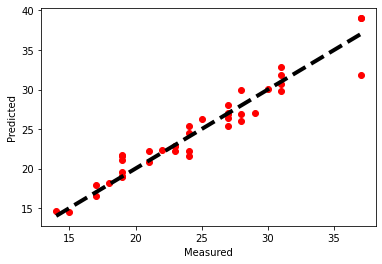

In [153]:
# plot the predicted vs measured MPG for the Test data
plt.plot(y_test, np.exp(model_DS2_Final.predict(X_test)), 'ro')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted');

In [154]:
corr_matrix = np.corrcoef(y_test, model_DS2_Final.predict(X_test))
corr = corr_matrix[0,1]
R_sq = corr**2
 
print("The R^2 value for the test data is:" + str(R_sq))

The R^2 value for the test data is:0.9231846411153068


### QQ Plot

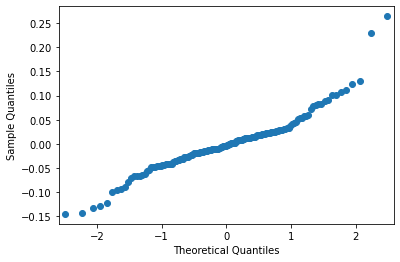

In [155]:
sm.qqplot(model_DS2_Final.resid);

### Leverage vs Normalized Residuals

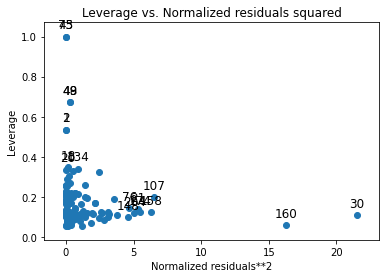

In [156]:
sm.graphics.plot_leverage_resid2(model_DS2_Final, alpha=0.05);

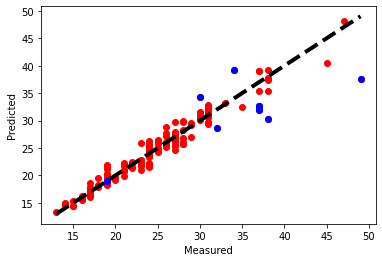

In [158]:
lev = [158,76,160,21, 75,76,174,141,118, 30]
predicts = np.exp(model_DS2_Final.predict(X_3))

plt.plot(y_3, predicts, 'ro');
plt.plot([y_3.min(), y_3.max()], [y_3.min(), y_3.max()], 'k--', lw=4)
plt.plot(y_3[lev], predicts[lev], 'bo');
plt.xlabel('Measured')
plt.ylabel('Predicted');

### Calculate Variance Inflation Factors

In [159]:
test = df2.copy()
test['fuel_type'] = test['fuel_type'].map({'diesel':0, 'gas':1})
test['make'] = test['make'].map({'audi':0, 'bmw':1, 'chevrolet':2,'dodge':3,'honda':4,'isuzu':5, 'jaguar':6,'mazda':7,'mercedes-benz':8,
                                'mercury':9,'mitsubishi':10,'nissan':11,'peugot':12,'plymouth':13,'porsche':14,'saab':15,
                                'subaru':16,'toyota':17,'volkswagen':18,'volvo':19, 'alfa-romero':20,})
X = test[['horsepower', 'fuel_type', 'make', 'curb_weight', 'stroke', 'compression_ratio']]



vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

             feature         VIF
0         horsepower   27.221566
1          fuel_type   33.526328
2               make    5.455557
3        curb_weight   76.078322
4             stroke  102.993320
5  compression_ratio   37.023289


## Analysis of final model before eliminating terms

The model for dataset 2 performed better than the model for dataset 1. Before removing terms to account for multicollinearity issues the model achieves high 80's low 90's R^2 values for both training and testing datasets. The predicted vs measured values plot does show that this model also struggles to accurately predict the higher MPG cars. The model doesn't systematically always underproduce but the delta between the measured and predicted MPG is much larger for higher MPG vehicles. 

The QQ plot is slightly less linear than the QQ plot for the dataset 1 model. There is still significant deviationions from linearity at either end of the plot. This alligns with the model not being as accuracte for high/low MPG values. 

This model also has a significant amount of high leveraged / residual data. Its hard to tell with datapoint overlap but it does not look to be as bad as the model for dataset 1. 

The biggest problem with this model currently is the VIF is very high for horespower, curb_weight and stroke attributes indicating there is significant multicollinearity. additionally the model was flagged in the summary output for having a high condition number indicating multicollinearity. We will remove terms in an attempt to reduce this multicollinearity. 

## Low Multicolinearity Model

The compression_ratio, curb_weight and stroke attributes were removed from the model in order to reduce the multicollinearity. 

### Build train / test dataset and train model

In [182]:
X_4 = df2.copy()
y_4 = X_4['city_mpg']

X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.20)

Train = X_train.copy()
Train['city_mpg'] = y_train

Test= X_train.copy()
Test['city_mpg'] = y_test

model_DS2_Final_lowmc = smf.ols(formula='np.log(city_mpg) ~ np.log(horsepower) + fuel_type + make + compression_ratio', data=Train).fit()
model_DS2_Final_lowmc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(city_mpg)   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     62.60
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           4.28e-59
Time:                        02:02:42   Log-Likelihood:                 183.71
No. Observations:                 154   AIC:                            -319.4
Df Residuals:                     130   BIC:                            -246.5
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.8089      0.378     12.709      0.000       4.060       5.557
fuel_type[T.gas]          0.3925      0.174      2.259      0.026       0.049       0.736
make[T.audi]             -0.0793      0.059     -1.352      0.179      -0.195       0.037
make[T.bmw]              -0.0007      0.061     -0.012      0.990      -0.122       0.121
make[T.chevrolet]         0.3017      0.068      4.442      0.000       0.167       0.436
make[T.dodge]             0.0816      0.058      1.398      0.164      -0.034       0.197
make[T.honda]             0.1435      0.054      2.682      0.008       0.038       0.249
make[T.isuzu]            -0.0352      0.074     -0.475      0.636      -0.182       0.111
make[T.jaguar]           -0.1021      0.067     -1.519      0.131      -0.235       0.031
make[T.mazda]             0.0683      0.055      1.243      0.216      -0.040       0.177
make[T.mercedes-benz]    -0.0853      0.059     -1.449      0.150      -0.202       0.031
make[T.mercury]           0.1605      0.093      1.724      0.087      -0.024       0.345
make[T.mitsubishi]        0.1112      0.055      2.027      0.045       0.003       0.220
make[T.nissan]            0.0817      0.051      1.591      0.114      -0.020       0.183
make[T.peugot]           -0.0680      0.057     -1.196      0.234      -0.181       0.045
make[T.plymouth]          0.1087      0.060      1.813      0.072      -0.010       0.227
make[T.porsche]           0.0321      0.074      0.432      0.666      -0.115       0.179
make[T.saab]             -0.0200      0.058     -0.343      0.732      -0.136       0.096
make[T.subaru]            0.0617      0.055      1.129      0.261      -0.046       0.170
make[T.toyota]            0.0795      0.049      1.616      0.109      -0.018       0.177
make[T.volkswagen]        0.0139      0.055      0.253      0.800      -0.095       0.123
make[T.volvo]             0.0115      0.054      0.212      0.833      -0.096       0.119
np.log(horsepower)       -0.5339      0.030    -17.714      0.000      -0.593      -0.474
compression_ratio         0.0425      0.013      3.230      0.002       0.016       0.069
==============================================================================
Omnibus:                       15.726   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.167
Skew:                           0.441   Prob(JB):                     1.71e-07
Kurtosis:                       5.020   Cond. No.                         776.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Predict Test Data MPG

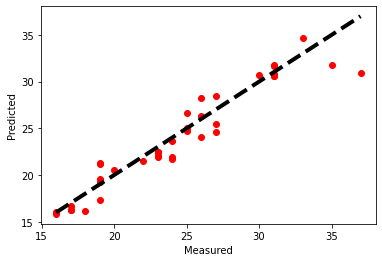

In [183]:
plt.plot(y_test, np.exp(model_DS2_Final_lowmc.predict(X_test)), 'ro')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted');

### Calculate R^2 Value for test Data

In [184]:
corr_matrix = np.corrcoef(y_test, model_DS2_Final_lowmc.predict(X_test))
corr = corr_matrix[0,1]
R_sq = corr**2
 
print("The R^2 value for the test data is:" + str(R_sq))

The R^2 value for the test data is:0.9017367536806119


### QQ Plot

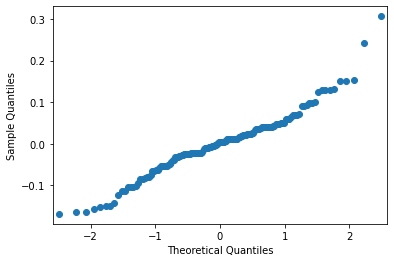

In [185]:
sm.qqplot(model_DS2_Final_lowmc.resid);

### Leverage vs Normalized Residuals

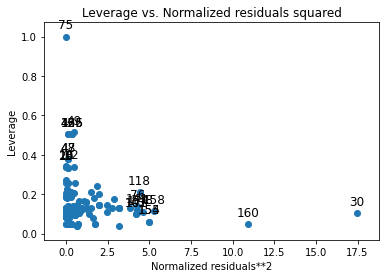

In [186]:
sm.graphics.plot_leverage_resid2(model_DS2_Final_lowmc, alpha=0.05);

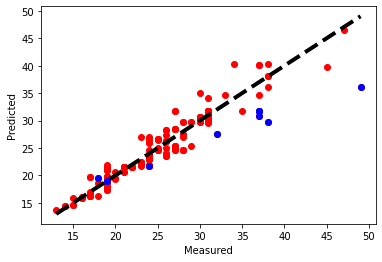

In [187]:
lev = [75,202,118,3,141,21,76,160,30]
predicts = np.exp(model_DS2_Final_lowmc.predict(X_4))

plt.plot(y_4, predicts, 'ro');
plt.plot([y_4.min(), y_4.max()], [y_4.min(), y_4.max()], 'k--', lw=4)
plt.plot(y_4[lev], predicts[lev], 'bo');
plt.xlabel('Measured')
plt.ylabel('Predicted');

### Variance Inflation Factors

In [188]:
test = df2.copy()
test['fuel_type'] = test['fuel_type'].map({'diesel':0, 'gas':1})
test['make'] = test['make'].map({'audi':0, 'bmw':1, 'chevrolet':2,'dodge':3,'honda':4,'isuzu':5, 'jaguar':6,'mazda':7,'mercedes-benz':8,
                                'mercury':9,'mitsubishi':10,'nissan':11,'peugot':12,'plymouth':13,'porsche':14,'saab':15,
                                'subaru':16,'toyota':17,'volkswagen':18,'volvo':19, 'alfa-romero':20,})
X = test[['horsepower', 'fuel_type', 'make', 'compression_ratio']]



vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

             feature       VIF
0         horsepower  8.307978
1          fuel_type  6.643309
2               make  4.992963
3  compression_ratio  4.941309


## Analysis of final model after eliminating terms

After the curb_weight and stroke attributes were removed from the model the model still maintained a good level of performance. The R^2 values for both the training and test datasets were mid 80's to low 90's but lower than the model before removing the terms. 

Looking at the plot of predicted vs measured MPG it again looks like this model struggles to accurately predict higher MPG vehicles. Additionally, the QQ plot is linear in the middle range but deviates on either end indicating the model predictions are not accurate on either end of the model. The model is still influenced by a significant number of high leverage and residual datapoints but not as bad as the models for dataset #1.

However, eliminating the curb_weight and stroke attributes dramatically reduced the VIF and condition number. All the VIF numbers were less than 10 and the condition number is low enough not to be flagged by the statsmodel fit function.

One interesting thing to note about this model is the majority of the make terms are not statistically relevant. On the full dataset and most of the iterations run with the test/train split chevy and honda were some of the few consistently relevant terms for make.

# Conclusion

Overall both datasets were "successfully" modeled with different regression models. A final model was developed for each dataset that provided reasonable accuracy for predicting MPG on a test/train split dataset. Overall the model developed from dataset 2 was more successful and provided better insight.

The significant terms for the first dataset were weight and model year. The model year term added significant multicollinearity but added a decent amount of model accuracy. The significant terms for the second data set were horsepower, fuel type, compression ratio, and make. This model did not suffer from multicollinearity. The initial proposal was linear regression but based on the data analysis it was clear that many of the terms were not linearly related to MPG. From early model iterations it was determined that many of the attributes in both datasets were logarithmically related to MPG.

The biggest surprise to both models was the level of correlation. Both models were limited heavily in term quantity by multicollinearity. Additionally terms that seemed relevant did not provide statistical significance after 2-3 terms in the model were added. Due to the higher coorelated nature of the data pretty much all of the interaction terms resulted in variance inflation factors well above the recommended 5-10 threshold. 

Both models had QQ plots that had significant deviations from linearity at either end. This indicates that both models struggle to predict data for low and high MPG vehicles. From this it is very likely that neither model is suitable for predictions on data not similar to the data the model was built upon. This probably eliminates much of the utility of these models for MPG prediction, however they still provide inference into attributes that impact MPG.

While the models ended with no overlap between terms it is clear from the data that horsepower and weight are significantly correlated, and these were the terms that had the most impact on model performance. The log of MPG is negatively related to the log of weight and horsepower. Additionally, the first model points to model year impacting fuel economy. The second model points to manufacturer impacting fuel economy as well as fuel type. While none of that is revolutionary knowledge and would seem logical, this reaffirms the model output. 

This project did not explore possibly transforming the attributes for example creating a weight/horsepower attribute. This might be able to improve model performance. The interactions of these terms though added too much multicollinearity.

To develop a model suitable for MPG prediction a larger dataset would most likely need to be developed that didn't share some of the inherent bias these two datasets had. From the data analysis section is clear both datasets have a bias towards region and specific car types in the data. This most likely hinders each model performance for predicting MPG on vehicles not similar to those in the data sets (from different years etc.).

One goal of this project was to potentially combine the models into 1 model. Due to the severe correlation it isn't feasible to combine the models as the main terms in both models are collinear. Unfortunately this goal was not met. However, with a broader dataset the ultimate goal of a model that accurately predicts MPG could better be achieved. Ideally the attributes tracked for this dataset could be guided by the attributes identified from these two models.